In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Load Moseq & Stats Dataframes

In [2]:
moseq_df = pd.read_csv('/om2/user/mabdel03/files/BTI/Moseq_3-27-2025_Run/Offsprings/data/moseq_df/moseq_df.csv')
stats_df = pd.read_csv('/om2/user/mabdel03/files/BTI/Moseq_3-27-2025_Run/Offsprings/data/stats_df/stats_df.csv')

# Useful Functions

In [3]:
uuid_NameMap = {}
for row in moseq_df.index:
    if moseq_df['uuid'][row] not in uuid_NameMap:
        uuid_NameMap[moseq_df['uuid'][row]] = moseq_df['SessionName'][row]

In [4]:
def rename_groups(df):
    
    """
    Function that takes a dataframe as input
    Returns the same dataframe but with a new category column
    Category column contains updated group labels accounting for different controls
    """
    
    new_cat = []
    
    for row in df.index:
    
        if df['group'][row].split('_')[0] == 'NGH':
            NGHtype = uuid_NameMap[df['uuid'][row]]
            if NGHtype.split('_')[-1].startswith('05'):
                new_cat.append('Ctrl-LNB')
            elif NGHtype.split('_')[-1].startswith('03'):
                new_cat.append('Ctrl-EE/SI')
        else:
            new_cat.append(df['group'][row].split('_')[0])

    df['category'] = new_cat
    
    return df

In [5]:
import pandas as pd
import numpy as np
from scipy.stats import kruskal
from statsmodels.stats.multitest import multipletests

def run_kruskal(df, cat, ctrl,
                group_col='category',
                x_col='syllable',
                y_col='usage'):
    """
    For each unique x_col, run a Kruskal–Wallis test comparing
      y_col in cat vs. ctrl.
    Skips any syllable where either group has <2 observations
    or where all values are identical.
    Returns a DataFrame with columns:
      ['Syllable','P_Value','FDR_Corrected_P_Value']
    """
    results = []
    for syl in sorted(df[x_col].dropna().unique()):
        grp = df[(df[group_col]==cat)  & (df[x_col]==syl)][y_col]
        ref = df[(df[group_col]==ctrl) & (df[x_col]==syl)][y_col]

        # skip too few samples
        if len(grp) < 2 or len(ref) < 2:
            continue

        # skip if both groups are constant and equal
        if grp.nunique()==1 and ref.nunique()==1 \
           and grp.iloc[0] == ref.iloc[0]:
            continue

        # attempt the test, but catch identical‐values error
        try:
            stat, p = kruskal(grp, ref)
        except ValueError:
            continue

        results.append({'Syllable': syl, 'P_Value': p})

    # build DataFrame
    p_df = pd.DataFrame(results, columns=['Syllable','P_Value'])
    # ensure the FDR column even if empty
    p_df['FDR_Corrected_P_Value'] = np.nan

    if not p_df.empty:
        raw_p = p_df['P_Value'].values
        _, fdr_p, _, _ = multipletests(raw_p, method='fdr_bh')
        p_df['FDR_Corrected_P_Value'] = fdr_p

    return p_df


In [6]:
def reformat_df(subset_df, metric_interest):
    """
    Take multi-index summary dataframe from Moseq fingerprint code as well as a metric of interest
    Reformat into single index dataframe for further analysis
    Returns dataframe with category label, position, uuid, and avg_time for that uuid in that metric
    """

    category = []
    position = []
    uuid_num = []
    avg_time = []
    
    for ix in subset_df[metric_interest]:
        for cat, uuid in subset_df[metric_interest][ix].index:
            category.append(cat)
            position.append(ix)
            uuid_num.append(uuid)
            avg_time.append(subset_df[metric_interest][ix][cat][uuid])
    
    
    return rename_groups(pd.DataFrame(data={'group': category, 'Metric': position, 'uuid': uuid_num, 'avg_time': avg_time}))


In [7]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

def pairwise_plots(df, plot_type, Title, X_label, Y_label,
                   stat_test=None, x_range=None,
                   save_dir='/om2/user/mabdel03/files/BTI'):
    """
    Produce pairwise line‐plots comparing each group vs. its control,
    with optional Mann–Whitney annotations.
    """
    os.makedirs(save_dir, exist_ok=True)
    categories = [('EE', 'Ctrl-EE/SI'),
                  ('SI', 'Ctrl-EE/SI'),
                  ('LNB', 'Ctrl-LNB')]
    x_var, y_var = plot_type

    custom_palette = {
        'EE': 'red', 'Ctrl-EE/SI': 'green',
        'SI': 'red', 'LNB': 'red', 'Ctrl-LNB': 'green'
    }

    fig, axes = plt.subplots(1, len(categories),
                             figsize=(5*len(categories), 4),
                             sharey=True)

    for i, (cat, ctrl) in enumerate(categories):
        ax = axes[i]
        # subset to just these two categories
        sub = df[df['category'].isin([cat, ctrl])]

        sns.lineplot(
            ax=ax,
            data=sub,
            x=x_var, y=y_var,
            hue='category',
            palette=custom_palette
        )

        ax.set_title(f'{cat} vs. {ctrl}')
        ax.set_xlabel(X_label)
        ax.set_ylabel(Y_label)
        if x_range is not None:
            ax.set_xlim(x_range)
        ax.tick_params(axis='x', rotation=45)

        # --- stat annotation ---
        if stat_test == 'mann-whit':
            # test at each x-value where both groups have data
            x_vals = sorted(sub[x_var].dropna().unique())
            for xv in x_vals:
                grp_vals  = sub[(sub['category']==cat)&(sub[x_var]==xv)][y_var]
                ctrl_vals = sub[(sub['category']==ctrl)&(sub[x_var]==xv)][y_var]
                if len(grp_vals)>=1 and len(ctrl_vals)>=1:
                    stat, p = mannwhitneyu(grp_vals, ctrl_vals,
                                           alternative='two-sided')
                    if p < 0.05:
                        top = max(grp_vals.max(), ctrl_vals.max())
                        ax.text(xv, top*1.02, '*',
                                ha='center', va='bottom', fontsize=14)

    plt.suptitle(Title, fontsize=16)
    plt.tight_layout(rect=[0,0,1,0.95])
    out_path = os.path.join(save_dir, f'{x_var}_pairwise.png')
    plt.savefig(out_path, dpi=300)
    plt.show()
    print(f'Figure saved to {out_path}')


In [8]:
from scipy.stats import mannwhitneyu
def mann_whit(df, cat, ctrl, x_lab, y_lab):
    # Get unique positions (metrics)
    positions = df[y_lab].unique()
    
    # Initialize a list to store the results
    results = []
    
    # Iterate through each position
    for position in positions:
        # Filter the data for the current position
        position_data = df[df[y_lab] == position]
        
        # Group data by category
        category_groups = position_data.groupby('group')[x_lab].apply(list)
        print(category_groups)
        
        if cat in category_groups and ctrl in category_groups:
            data_EE = category_groups[cat]
            data_SI = category_groups[ctrl]
            
            stat, p_value = mannwhitneyu(data_EE, data_SI)
            test_name = 'Mann-Whitney U test'
            
            # Append the result for the current position
            results.append({
                'Metric': position,
                'Test': test_name,
                'Statistic': stat,
                'P-Value': p_value
            })
            print(results)
    
    # Convert results to a DataFrame for easy viewing
    results_df = pd.DataFrame(results)
    print(results_df)

    
    results_df = results_df.dropna(subset='P-Value')
    
    # Apply FDR (Benjamini-Hochberg) correction
    reject, pvals_corrected, _, _ = multipletests(results_df['P-Value'], method='fdr_bh')
    
    # Add the corrected p-values to the DataFrame
    results_df['FDR_Corrected_P'] = pvals_corrected
    
    return results_df[results_df['P-Value'] <= 0.1]
    


In [9]:
from scipy.stats import mannwhitneyu

def boring_mann_whit(df, cat, ctrl, x_lab, y_lab):
    
    # Step 1: Aggregate data by uuid within each category
    aggregated_df = df.groupby(['category', 'uuid'])[y_lab].mean().reset_index()
    
    # Step 2: Filter the data for the two categories
    group_EE = aggregated_df[aggregated_df['category'] == cat][y_lab]
    group_SI = aggregated_df[aggregated_df['category'] == ctrl][y_lab]
    
    # Ensure both groups have data
    if len(group_EE) > 0 and len(group_SI) > 0:
        # Perform the Mann-Whitney U test on the aggregated data
        stat, p_value = mannwhitneyu(group_EE, group_SI, alternative='two-sided')
        
        # Display the result
        print(f'Mann-Whitney U Statistic: {stat}')
        print(f'P-Value: {p_value}')

# Subsetting Dataframes And Reorganizing--Male/Female, Relabeling NGH

In [10]:
stats_NoMoms = stats_df[stats_df['group'].apply(lambda x: x.split('_')[1] != 'Mom')]

In [11]:
male_stats = stats_NoMoms[stats_NoMoms['group'].apply(lambda x: x.split('_')[2] == 'Male')]

In [12]:
female_stats = stats_NoMoms[stats_NoMoms['group'].apply(lambda x: x.split('_')[2] == 'Female')]

In [13]:
male_cat = []
for row in male_stats.index:
    if male_stats['group'][row].split('_')[0] == 'NGH':
        NGHtype = uuid_NameMap[male_stats['uuid'][row]]
        if NGHtype.split('_')[-1].startswith('05'):
            male_cat.append('NGH-LNB')
        elif NGHtype.split('_')[-1].startswith('03'):
            male_cat.append('NGH-EE/SI')
    else:
        male_cat.append(male_stats['group'][row].split('_')[0])

In [14]:
male_stats['category'] = male_cat

/tmp/ipykernel_3244821/4128997696.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  male_stats['category'] = male_cat


In [15]:
female_cat = []
for row in female_stats.index:
    if female_stats['group'][row].split('_')[0] == 'NGH':
        NGHtype = uuid_NameMap[female_stats['uuid'][row]]
        if NGHtype.split('_')[-1].startswith('05'):
            female_cat.append('NGH-LNB')
        elif NGHtype.split('_')[-1].startswith('03'):
            female_cat.append('NGH-EE/SI')
    else:
        female_cat.append(female_stats['group'][row].split('_')[0])

female_stats['category'] = female_cat

/tmp/ipykernel_3244821/38062902.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  female_stats['category'] = female_cat


In [16]:
"""
Pairwise Comparisons:
EE vs. NGH-EE/SI
SI vs NGH-EE/SI
LNB vs NGH-LNB
"""

'\nPairwise Comparisons:\nEE vs. NGH-EE/SI\nSI vs NGH-EE/SI\nLNB vs NGH-LNB\n'

# Syllable Usage Analysis

In [17]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import mannwhitneyu
from scipy.stats import f_oneway
from statsmodels.multivariate.manova import MANOVA

### Run Renaming Code

In [18]:
male_stats = rename_groups(male_stats)

/tmp/ipykernel_3244821/61600432.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['category'] = new_cat


In [19]:
female_stats = rename_groups(female_stats)

/tmp/ipykernel_3244821/61600432.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['category'] = new_cat


### Male Plots & Stats

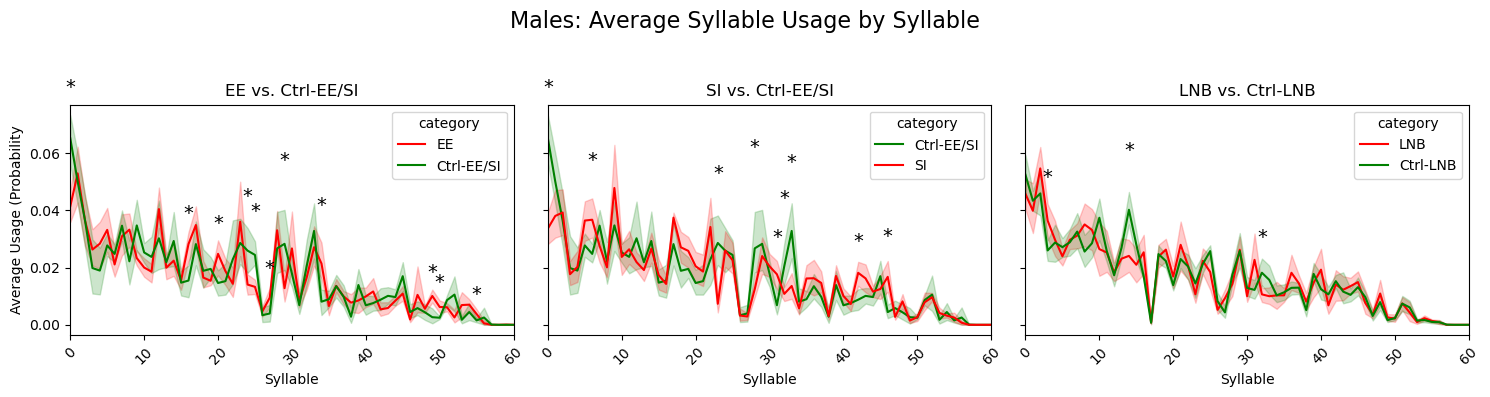

Figure saved to /om2/user/mabdel03/files/BTI/syllable_pairwise.png


In [20]:
pairwise_plots(male_stats, ('syllable', 'usage'), 'Males: Average Syllable Usage by Syllable', 'Syllable', 'Average Usage (Probability', 'mann-whit', x_range=[0, 60], save_dir='/om2/user/mabdel03/files/BTI')

#### EE Vs. SI and LNB

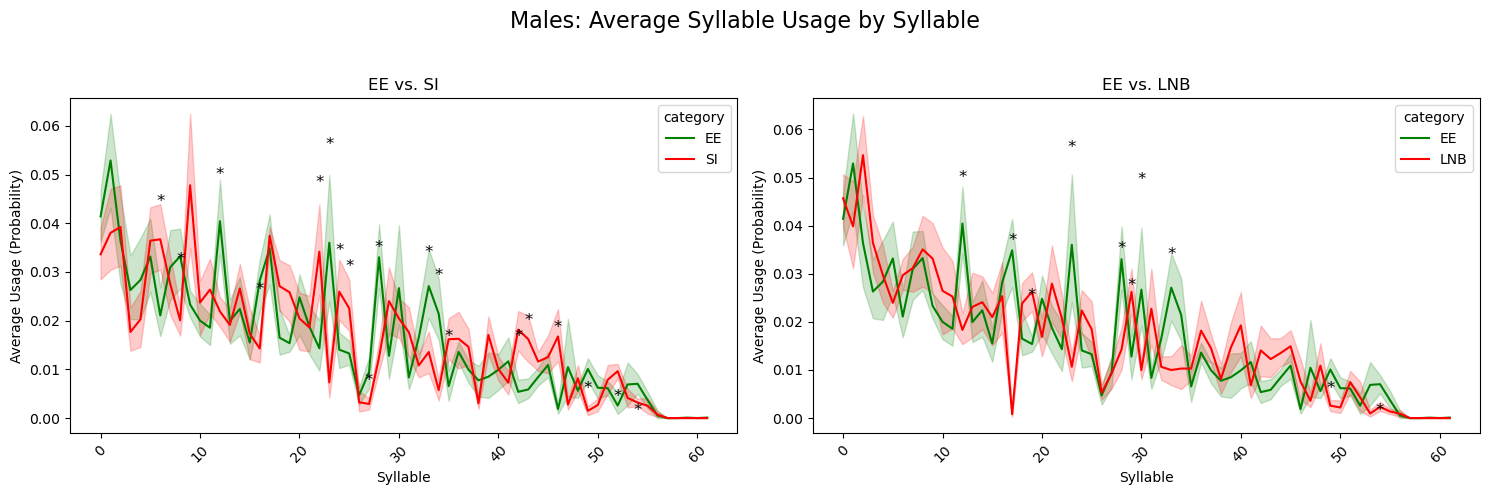

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

categories = [('EE', 'SI'), ('EE', 'LNB')]
male_subs = {'EE': '', 'SI': '', 'LNB': ''}

# Define a color palette where 'cat' is always blue and 'ctrl' is always orange
custom_palette = {'EE': 'green', 'Ctrl-EE/SI': 'green', 'SI': 'red', 'LNB': 'red', 'Ctrl-LNB': 'green'}

# Create a figure with subplots
fig, axes = plt.subplots(1, len(categories), figsize=(15, 5))  # Adjust the number of columns based on the number of categories

for i, (cat, ctrl) in enumerate(categories):
    male_subs[cat] = male_stats[(male_stats['category'] == cat) | (male_stats['category'] == ctrl)]

    # Fit the two-way ANOVA model
    model = ols('usage ~ C(syllable) * C(category)', data=male_subs[cat]).fit()

    # Separate the data into two groups based on the category
    cat_usage = male_subs[cat][male_subs[cat]['category'] == cat]['usage']
    ctrl_usage = male_subs[cat][male_subs[cat]['category'] == ctrl]['usage']

    """
    # Perform the Mann-Whitney U test
    u_stat, p_value = mannwhitneyu(cat_usage, ctrl_usage)
    print(f"U-statistic: {u_stat}, P-value: {p_value}")

    f_stat, p_value = f_oneway(cat_usage, ctrl_usage)
    print(f"F-statistic: {f_stat}, P-value: {p_value}")

    """

    """
    # Perform ANOVA
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(cat + ' vs. ' + ctrl)
    print(anova_table)
    print('\n')

    """

    p_values_df = run_kruskal(male_subs[cat], cat, ctrl)
    p_values_df_sub = p_values_df[p_values_df['P_Value'] <= 0.05]
    suffix = cat + '_'+ ctrl.split('/')[0] + '.csv'
    root = os.path.join('/net/vast-storage/scratch/vast/lhtsai/mabdel03/files/BTI/Moseq/SuperCoolMeeting_I/Supp_Tables/Syllable_Usage/Males', suffix)
    p_values_df_sub.to_csv(root)

    # Plot the line plot on the corresponding subplot
    sns.lineplot(ax=axes[i], data=male_subs[cat], x='syllable', y='usage', hue='category', palette=custom_palette)
    axes[i].set_title(f'{cat} vs. {ctrl}')
    axes[i].set_xlabel('Syllable')
    axes[i].set_ylabel('Average Usage (Probability)')
    axes[i].tick_params(axis='x', rotation=45)  # Rotate labels if needed

    #P_Value
    #FDR_Corrected_P_Value
    for _, row in p_values_df.iterrows():
        if row['FDR_Corrected_P_Value'] <= 0.05:
            syllable = row['Syllable']
            # Get the y-position for the annotation (place above the maximum y value for that syllable)
            max_y = male_subs[cat][male_subs[cat]['syllable'] == syllable]['usage'].max()
            axes[i].text(syllable, max_y - 0.01, '*', ha='center', va='bottom', color='black', fontsize=12)

# Add an overall title for the entire figure
plt.suptitle('Males: Average Syllable Usage by Syllable', fontsize=16)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the rect parameter to leave space for the title

plt.savefig(f'/net/vast-storage/scratch/vast/lhtsai/mabdel03/files/BTI/Moseq/SuperCoolMeeting_I/Figures/Syllable_Usage/Male_EE-Condition_syllable_usage.png', dpi=300)

plt.show()


#### Normal Comparisons (Condition vs. Controls)

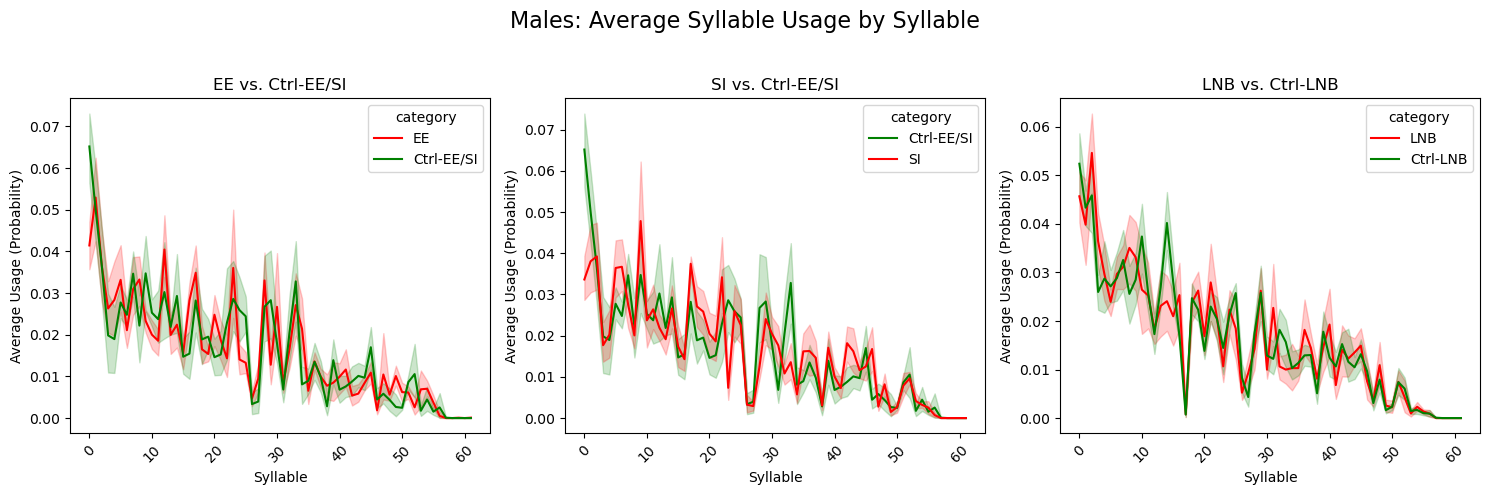

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

categories = [('EE', 'Ctrl-EE/SI'), ('SI', 'Ctrl-EE/SI'), ('LNB', 'Ctrl-LNB')]
male_subs = {'EE': '', 'SI': '', 'LNB': ''}

# Define a color palette where 'cat' is always blue and 'ctrl' is always orange
custom_palette = {'EE': 'red', 'Ctrl-EE/SI': 'green', 'SI': 'red', 'LNB': 'red', 'Ctrl-LNB': 'green'}

# Create a figure with subplots
fig, axes = plt.subplots(1, len(categories), figsize=(15, 5))  # Adjust the number of columns based on the number of categories

for i, (cat, ctrl) in enumerate(categories):
    male_subs[cat] = male_stats[(male_stats['category'] == cat) | (male_stats['category'] == ctrl)]

    # Fit the two-way ANOVA model
    model = ols('usage ~ C(syllable) * C(category)', data=male_subs[cat]).fit()

    # Separate the data into two groups based on the category
    cat_usage = male_subs[cat][male_subs[cat]['category'] == cat]['usage']
    ctrl_usage = male_subs[cat][male_subs[cat]['category'] == ctrl]['usage']

    """
    # Perform the Mann-Whitney U test
    u_stat, p_value = mannwhitneyu(cat_usage, ctrl_usage)
    print(f"U-statistic: {u_stat}, P-value: {p_value}")

    f_stat, p_value = f_oneway(cat_usage, ctrl_usage)
    print(f"F-statistic: {f_stat}, P-value: {p_value}")

    """

    """
    # Perform ANOVA
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(cat + ' vs. ' + ctrl)
    print(anova_table)
    print('\n')

    """

    p_values_df = run_kruskal(male_subs[cat], cat, ctrl)
    p_values_df_sub = p_values_df[p_values_df['P_Value'] <= 0.05]
    suffix = cat + '_'+ ctrl.split('/')[0] + '.csv'
    root = os.path.join('/net/vast-storage/scratch/vast/lhtsai/mabdel03/files/BTI/Moseq/SuperCoolMeeting_I/Supp_Tables/Syllable_Usage/Males', suffix)
    p_values_df_sub.to_csv(root)

    # Plot the line plot on the corresponding subplot
    sns.lineplot(ax=axes[i], data=male_subs[cat], x='syllable', y='usage', hue='category', palette=custom_palette)
    axes[i].set_title(f'{cat} vs. {ctrl}')
    axes[i].set_xlabel('Syllable')
    axes[i].set_ylabel('Average Usage (Probability)')
    axes[i].tick_params(axis='x', rotation=45)  # Rotate labels if needed

    for _, row in p_values_df.iterrows():
        if row['FDR_Corrected_P_Value'] <= 0.05:
            syllable = row['Syllable']
            # Get the y-position for the annotation (place above the maximum y value for that syllable)
            max_y = male_subs[cat][male_subs[cat]['syllable'] == syllable]['usage'].max()
            axes[i].text(syllable, max_y - 0.01, '*', ha='center', va='bottom', color='black', fontsize=12)

# Add an overall title for the entire figure
plt.suptitle('Males: Average Syllable Usage by Syllable', fontsize=16)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the rect parameter to leave space for the title

plt.savefig('/net/vast-storage/scratch/vast/lhtsai/mabdel03/files/BTI/Moseq/SuperCoolMeeting_I/Figures/Syllable_Usage/Male_average_syllable_usage.png', dpi=300)

plt.show()


### Control Comparisons (Male and Female)

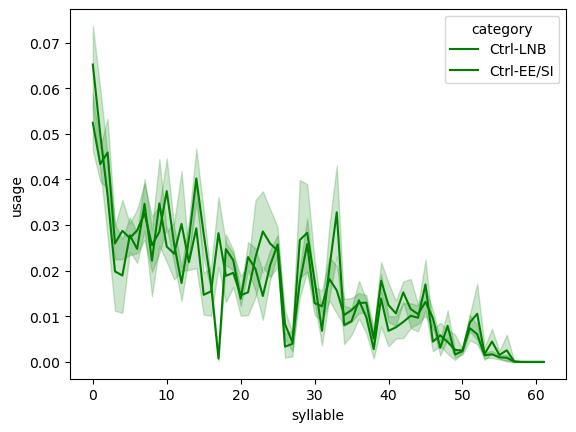

In [23]:
# build ctrl_sub by pulling from the subsets you already created
ctrl_lnb    = male_subs['LNB'][male_subs['LNB']['category']=='Ctrl-LNB']
ctrl_ee_si  = male_subs['EE'][ male_subs['EE']['category']=='Ctrl-EE/SI']
ctrl_sub    = pd.concat([ctrl_lnb, ctrl_ee_si], ignore_index=True)

sns.lineplot(data=ctrl_sub, x='syllable', y='usage', hue='category',
             palette=custom_palette)
plt.show()


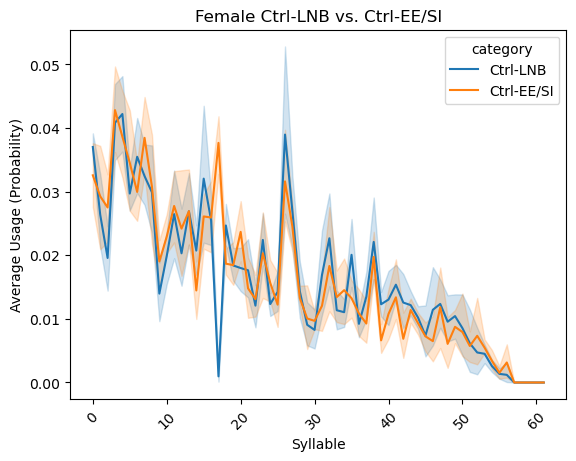

In [24]:
ctrl_sub = female_stats[(female_stats['category'] == 'Ctrl-LNB') | (female_stats['category'] == 'Ctrl-EE/SI')]
sns.lineplot(data=ctrl_sub, x='syllable', y='usage', hue='category')

plt.title('Female Ctrl-LNB vs. Ctrl-EE/SI')
plt.xlabel('Syllable')
plt.ylabel('Average Usage (Probability)')
plt.tick_params(axis='x', rotation=45)  # Rotate labels if needed

plt.show()

### Female Plots and Stats

#### EE Vs Conditions

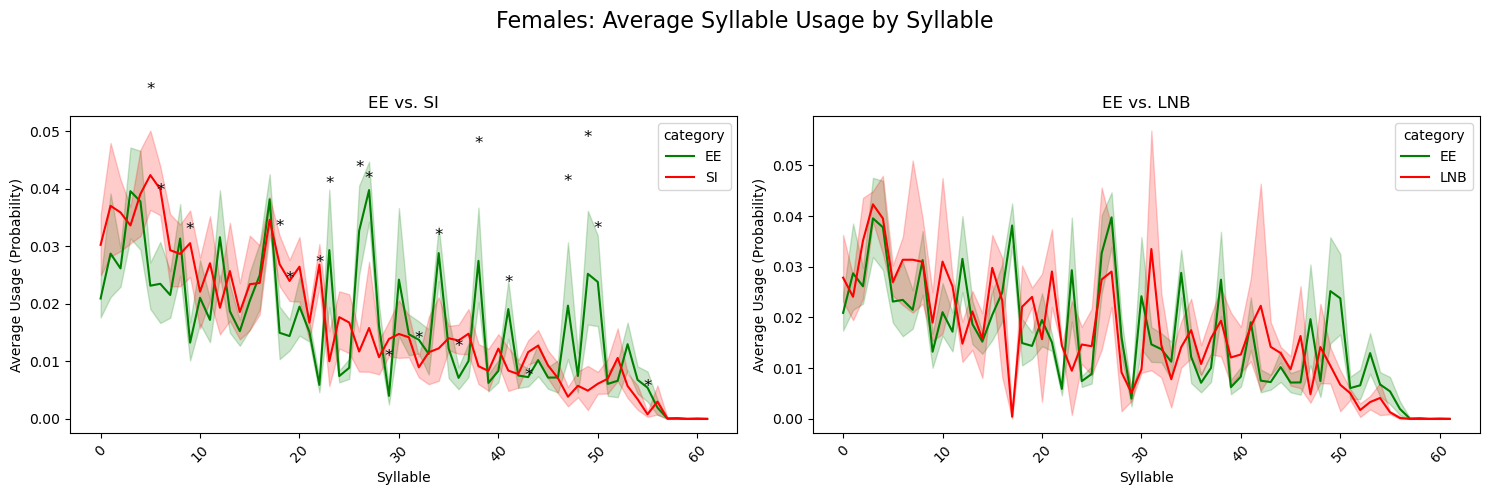

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

categories = [('EE', 'SI'), ('EE', 'LNB')]
male_subs = {'EE': '', 'SI': '', 'LNB': ''}

# Define a color palette where 'cat' is always blue and 'ctrl' is always orange
custom_palette = {'EE': 'green', 'Ctrl-EE/SI': 'green', 'SI': 'red', 'LNB': 'red', 'Ctrl-LNB': 'green'}

# Create a figure with subplots
fig, axes = plt.subplots(1, len(categories), figsize=(15, 5))  # Adjust the number of columns based on the number of categories

for i, (cat, ctrl) in enumerate(categories):
    male_subs[cat] = female_stats[(female_stats['category'] == cat) | (female_stats['category'] == ctrl)]

    # Fit the two-way ANOVA model
    model = ols('usage ~ C(syllable) * C(category)', data=male_subs[cat]).fit()

    # Separate the data into two groups based on the category
    cat_usage = male_subs[cat][male_subs[cat]['category'] == cat]['usage']
    ctrl_usage = male_subs[cat][male_subs[cat]['category'] == ctrl]['usage']

    """
    # Perform the Mann-Whitney U test
    u_stat, p_value = mannwhitneyu(cat_usage, ctrl_usage)
    print(f"U-statistic: {u_stat}, P-value: {p_value}")

    f_stat, p_value = f_oneway(cat_usage, ctrl_usage)
    print(f"F-statistic: {f_stat}, P-value: {p_value}")

    """

    """
    # Perform ANOVA
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(cat + ' vs. ' + ctrl)
    print(anova_table)
    print('\n')

    """

    p_values_df = run_kruskal(male_subs[cat], cat, ctrl)
    p_values_df_sub = p_values_df[p_values_df['P_Value'] <= 0.05]
    suffix = cat + '_'+ ctrl.split('/')[0] + '.csv'
    root = os.path.join('/net/vast-storage/scratch/vast/lhtsai/mabdel03/files/BTI/Moseq/SuperCoolMeeting_I/Supp_Tables/Syllable_Usage/Males', suffix)
    p_values_df_sub.to_csv(root)

    # Plot the line plot on the corresponding subplot
    sns.lineplot(ax=axes[i], data=male_subs[cat], x='syllable', y='usage', hue='category', palette=custom_palette)
    axes[i].set_title(f'{cat} vs. {ctrl}')
    axes[i].set_xlabel('Syllable')
    axes[i].set_ylabel('Average Usage (Probability)')
    axes[i].tick_params(axis='x', rotation=45)  # Rotate labels if needed

    #P_Value
    #FDR_Corrected_P_Value
    for _, row in p_values_df.iterrows():
        if row['FDR_Corrected_P_Value'] <= 0.05:
            syllable = row['Syllable']
            # Get the y-position for the annotation (place above the maximum y value for that syllable)
            max_y = male_subs[cat][male_subs[cat]['syllable'] == syllable]['usage'].max()
            axes[i].text(syllable, max_y - 0.01, '*', ha='center', va='bottom', color='black', fontsize=12)

# Add an overall title for the entire figure
plt.suptitle('Females: Average Syllable Usage by Syllable', fontsize=16)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the rect parameter to leave space for the title

plt.savefig(f'/net/vast-storage/scratch/vast/lhtsai/mabdel03/files/BTI/Moseq/SuperCoolMeeting_I/Figures/Syllable_Usage/Female_EE-Condition_syllable_usage.png', dpi=300)

plt.show()


#### Conditions Vs. Controls

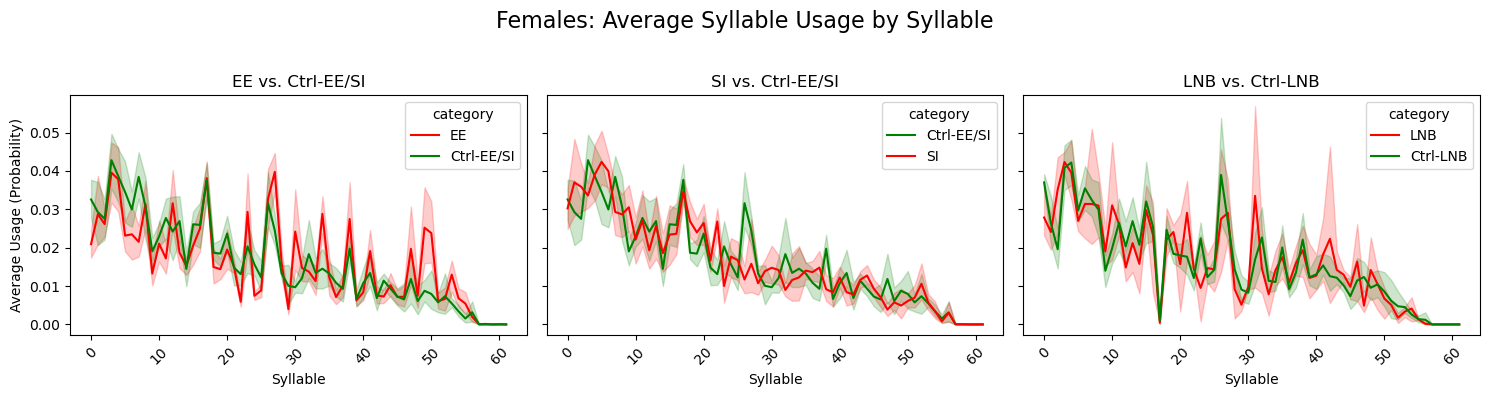

In [26]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols

# --------------------------------------------------------------------------------
# Plot settings
# --------------------------------------------------------------------------------
categories = [
    ('EE',  'Ctrl-EE/SI'),
    ('SI',  'Ctrl-EE/SI'),
    ('LNB', 'Ctrl-LNB')
]
custom_palette = {
    'EE':          'red',
    'Ctrl-EE/SI':  'green',
    'SI':          'red',
    'LNB':         'red',
    'Ctrl-LNB':    'green'
}

# where to save your tables and figures
table_dir  = '/net/vast-storage/scratch/vast/lhtsai/mabdel03/files/BTI/Moseq/SuperCoolMeeting_I/Supp_Tables/Syllable_Usage/Females'
fig_path   = '/net/vast-storage/scratch/vast/lhtsai/mabdel03/files/BTI/Moseq/SuperCoolMeeting_I/Figures/Syllable_Usage/Female_average_syllable_usage.png'
os.makedirs(table_dir, exist_ok=True)

# --------------------------------------------------------------------------------
# Generate sub-DataFrames and plot
# --------------------------------------------------------------------------------
fig, axes = plt.subplots(1, len(categories), figsize=(5*len(categories), 4), sharey=True)

for i, (cat, ctrl) in enumerate(categories):
    # 1) Subset your female_stats DataFrame
    df_sub = female_stats[female_stats['category'].isin([cat, ctrl])].copy()
    
    # 2) (Optional) Fit the two-way ANOVA if you need it later
    model = ols('usage ~ C(syllable) * C(category)', data=df_sub).fit()
    
    # 3) Run Kruskal–Wallis on each syllable and save significant results
    p_values_df = run_kruskal(df_sub, cat, ctrl)
    sig_df = p_values_df[p_values_df['P_Value'] <= 0.05]
    out_csv = os.path.join(table_dir, f"{cat}_{ctrl.split('/')[0]}.csv")
    sig_df.to_csv(out_csv, index=False)
    
    # 4) Plot the lineplot
    ax = axes[i]
    sns.lineplot(
        ax=ax,
        data=df_sub,
        x='syllable',
        y='usage',
        hue='category',
        palette=custom_palette
    )
    ax.set_title(f'{cat} vs. {ctrl}')
    ax.set_xlabel('Syllable')
    ax.set_ylabel('Average Usage (Probability)')
    ax.tick_params(axis='x', rotation=45)
    
    # 5) Annotate any FDR-significant syllables with a “*”
    for _, row in p_values_df.iterrows():
        if row['FDR_Corrected_P_Value'] <= 0.05:
            syl = row['Syllable']
            max_y = df_sub.loc[df_sub['syllable']==syl, 'usage'].max()
            ax.text(syl, max_y * 1.02, '*',
                    ha='center', va='bottom', fontsize=14)

# --------------------------------------------------------------------------------
# Final touches
# --------------------------------------------------------------------------------
plt.suptitle('Females: Average Syllable Usage by Syllable', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(fig_path, dpi=300)
plt.show()


# Fingerprint Analysis

## Load and Format Dataframes

In [27]:
summary_df = pd.read_csv('/om2/user/mabdel03/files/BTI/Moseq_3-27-2025_Run/Offsprings/data/fingerprint_csv/FingerprintSummary_full.csv', index_col=[0, 1], header=[0, 1])
range_dict = pd.read_csv('/om2/user/mabdel03/files/BTI/Moseq_3-27-2025_Run/Offsprings/data/fingerprint_csv/FingerprintRangeDict_full.csv')

In [28]:
noMoms_df = summary_df[~summary_df.index.get_level_values('group').str.contains('Mom')]

In [29]:
males_df = noMoms_df[noMoms_df.index.get_level_values('group').str.endswith('Male')]
females_df = noMoms_df[noMoms_df.index.get_level_values('group').str.endswith('Female')]

In [30]:
males_df.head()

dist_to_center_px  \
bin                                                                 0   
group          uuid                                                     
EE_Normal_Male 0e7e9b38-4cb6-400c-b0f5-6e4034920500          0.000111   
               37e31c07-bedb-4afd-a128-9e8eea3e6ed6          0.000056   
               50da788c-2302-41e3-bd7a-8e92b3e24d95          0.000028   
               92b48143-ece8-4749-aff3-73be8f258ece          0.000223   
               9af80187-1f8b-4a78-bdf6-9cdcaea7c7a8          0.000000   

                                                                         \
bin                                                         1         2   
group          uuid                                                       
EE_Normal_Male 0e7e9b38-4cb6-400c-b0f5-6e4034920500  0.000362  0.001391   
               37e31c07-bedb-4afd-a128-9e8eea3e6ed6  0.000223  0.000278   
               50da788c-2302-41e3-bd7a-8e92b3e24d95  0.000111  0.002225   
               92b48143-ece8-4749-aff3-73be8f258ece  0.000195  0.000083   
               9af80187-1f8b-4a78-bdf6-9cdcaea7c7a8  0.000083  0.000528   

                                                                         \
bin                                                         3         4   
group          uuid                                                       
EE_Normal_Male 0e7e9b38-4cb6-400c-b0f5-6e4034920500  0.000890  0.000834   
               37e31c07-bedb-4afd-a128-9e8eea3e6ed6  0.000807  0.000974   
               50da788c-2302-41e3-bd7a-8e92b3e24d95  0.001335  0.003032   
               92b48143-ece8-4749-aff3-73be8f258ece  0.000083  0.000417   
               9af80187-1f8b-4a78-bdf6-9cdcaea7c7a8  0.000528  0.000584   

                                                                         \
bin                                                         5         6   
group          uuid                                                       
EE_Normal_Male 0e7e9b38-4cb6-400c-b0f5-6e4034920500  0.001168  0.001947   
               37e31c07-bedb-4afd-a128-9e8eea3e6ed6  0.001252  0.001168   
               50da788c-2302-41e3-bd7a-8e92b3e24d95  0.005368  0.003115   
               92b48143-ece8-4749-aff3-73be8f258ece  0.000445  0.000862   
               9af80187-1f8b-4a78-bdf6-9cdcaea7c7a8  0.000667  0.001307   

                                                                         \
bin                                                         7         8   
group          uuid                                                       
EE_Normal_Male 0e7e9b38-4cb6-400c-b0f5-6e4034920500  0.003838  0.004172   
               37e31c07-bedb-4afd-a128-9e8eea3e6ed6  0.001697  0.003282   
               50da788c-2302-41e3-bd7a-8e92b3e24d95  0.003588  0.003171   
               92b48143-ece8-4749-aff3-73be8f258ece  0.000890  0.000973   
               9af80187-1f8b-4a78-bdf6-9cdcaea7c7a8  0.001390  0.001613   

                                                               ...     MoSeq  \
bin                                                         9  ...        52   
group          uuid                                            ...             
EE_Normal_Male 0e7e9b38-4cb6-400c-b0f5-6e4034920500  0.002642  ...  0.002385   
               37e31c07-bedb-4afd-a128-9e8eea3e6ed6  0.003282  ...  0.000954   
               50da788c-2302-41e3-bd7a-8e92b3e24d95  0.002364  ...  0.001671   
               92b48143-ece8-4749-aff3-73be8f258ece  0.000834  ...  0.008854   
               9af80187-1f8b-4a78-bdf6-9cdcaea7c7a8  0.002419  ...  0.001576   

                                                                         \
bin                                                        53        54   
group          uuid                                                       
EE_Normal_Male 0e7e9b38-4cb6-400c-b0f5-6e4034920500  0.004294  0.010019   
               37e31c07-bedb-4afd-a128-9e8eea3e6ed6  0.004292  0.007630   
               50da788c-2302-41e3-bd7a-8e92b3e2

In [31]:
list(set(column[0] for column in summary_df.columns))

['height_ave_mm', 'dist_to_center_px', 'velocity_2d_mm', 'MoSeq', 'length_mm']

## Position

In [32]:
root = '/om2/user/mabdel03/files/BTI/Moseq_3-27-2025_Run/Offsprings/figs/Scalar_Figs/Position'

### Males

In [33]:
m_pos_df = reformat_df(males_df, 'dist_to_center_px')
m_pos_df = rename_groups(m_pos_df)

In [34]:
save_dir = os.path.join(root, 'Males')

In [35]:
m_pos_df

group Metric                                  uuid  avg_time  \
0     EE_Normal_Male      0  0e7e9b38-4cb6-400c-b0f5-6e4034920500  0.000111   
1     EE_Normal_Male      0  37e31c07-bedb-4afd-a128-9e8eea3e6ed6  0.000056   
2     EE_Normal_Male      0  50da788c-2302-41e3-bd7a-8e92b3e24d95  0.000028   
3     EE_Normal_Male      0  92b48143-ece8-4749-aff3-73be8f258ece  0.000223   
4     EE_Normal_Male      0  9af80187-1f8b-4a78-bdf6-9cdcaea7c7a8  0.000000   
...              ...    ...                                   ...       ...   
3262  SI_Normal_Male     98  967cea17-5b5e-4166-b0da-81fa56b8ad1a  0.000000   
3263  SI_Normal_Male     98  a9a43e79-be6d-43f9-afcc-684fd0bdeafc  0.000000   
3264  SI_Normal_Male     98  be2c69ec-d004-4d52-b844-13e9634737ed  0.000000   
3265  SI_Normal_Male     98  d5fe97bf-c8c6-4400-bd91-1a355888d818  0.000000   
3266  SI_Normal_Male     98  dbdc0682-0cc4-47f8-bd56-031dd6739b00  0.000000   

     category  
0          EE  
1          EE  
2          EE  
3          EE  
4          EE  
...       ...  
3262       SI  
3263       SI  
3264       SI  
3265       SI  
3266       SI  

[3267 rows x 5 columns]

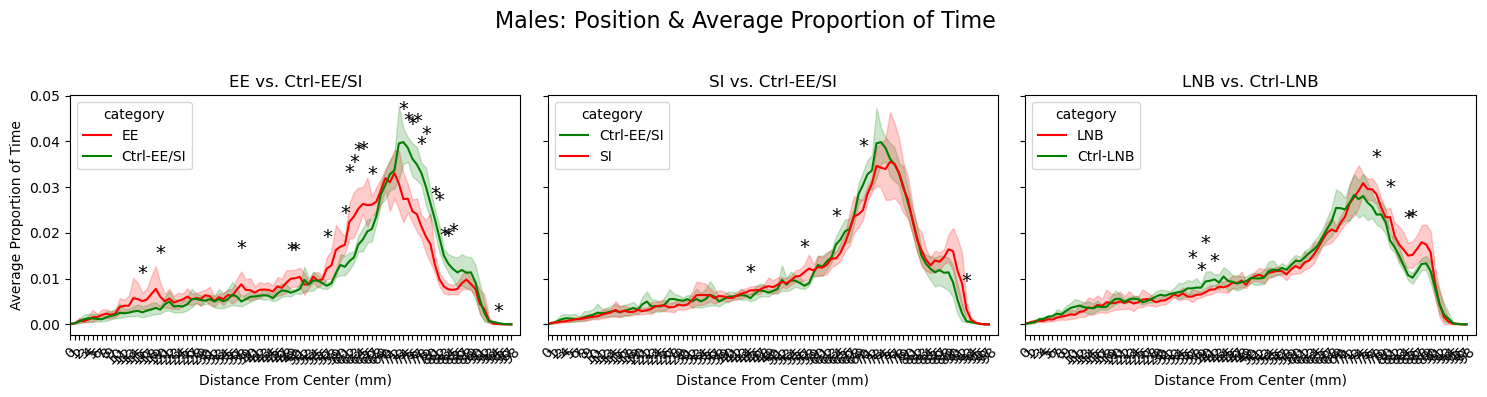

Figure saved to /om2/user/mabdel03/files/BTI/Moseq_3-27-2025_Run/Offsprings/figs/Scalar_Figs/Position/Males/Metric_pairwise.png


In [36]:
#(df, plot_type, Title, X_label, Y_label, stat_test)
pairwise_plots(m_pos_df, ('Metric', 'avg_time'), 'Males: Position & Average Proportion of Time', 'Distance From Center (mm)', 'Average Proportion of Time', 'mann-whit', [0, 100], save_dir)

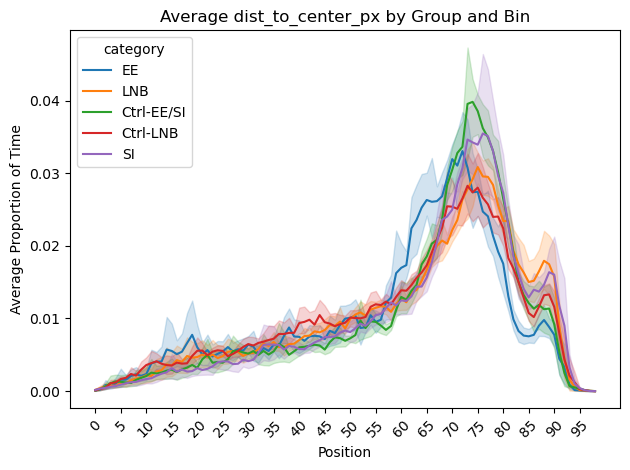

In [37]:
sns.lineplot(data=m_pos_df, x='Metric', y='avg_time', hue='category')
plt.xticks(ticks=range(0, len(m_pos_df['Metric'].unique()), 5))
# Customize the plot
plt.title('Average dist_to_center_px by Group and Bin')
plt.xlabel('Position')
plt.ylabel('Average Proportion of Time')
plt.xticks(rotation=45)  # Rotate labels if needed
plt.tight_layout()

### Females

In [38]:
f_pos_df = reformat_df(females_df, 'dist_to_center_px')
f_pos_df = rename_groups(f_pos_df)
save_dir = os.path.join(root, 'Females')

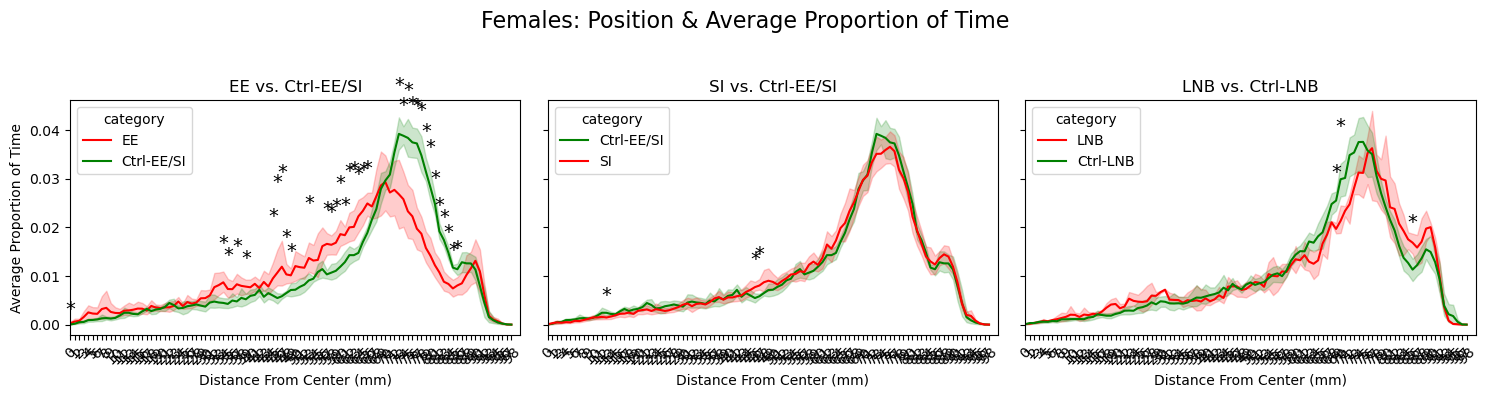

Figure saved to /om2/user/mabdel03/files/BTI/Moseq_3-27-2025_Run/Offsprings/figs/Scalar_Figs/Position/Females/Metric_pairwise.png


In [39]:
pairwise_plots(f_pos_df, ('Metric', 'avg_time'), 'Females: Position & Average Proportion of Time', 'Distance From Center (mm)', 'Average Proportion of Time', 'mann-whit', [0, 100], save_dir)

## Velocity

In [40]:
root = '/net/vast-storage/scratch/vast/lhtsai/mabdel03/files/BTI/Moseq/SuperCoolMeeting_I/Figures/Scalars/Velocity'

### Males

In [41]:
m_pos_df = reformat_df(males_df, 'velocity_2d_mm')
m_pos_df = rename_groups(m_pos_df)

In [42]:
save_dir = os.path.join(root, 'Males')

/tmp/ipykernel_3244821/4183132373.py:64: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout(rect=[0,0,1,0.95])


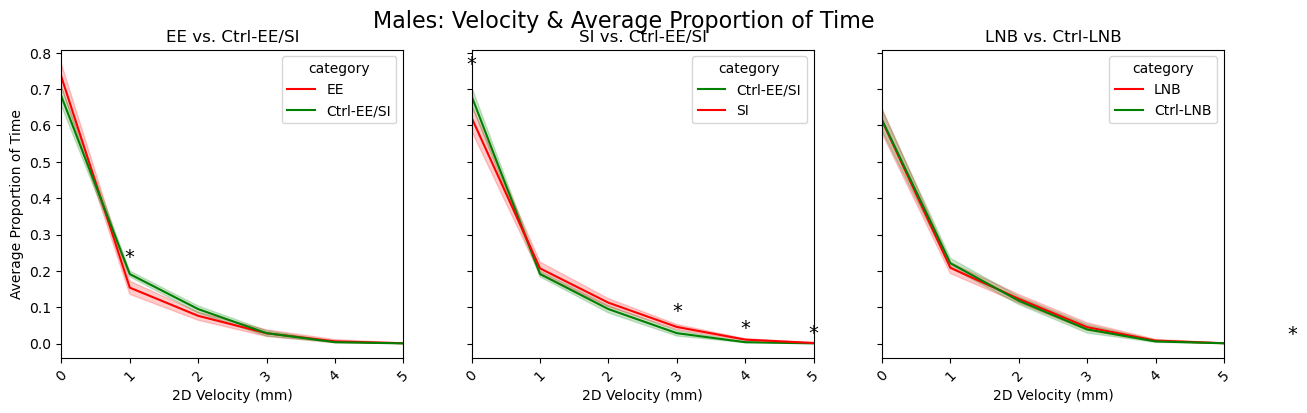

Figure saved to /net/vast-storage/scratch/vast/lhtsai/mabdel03/files/BTI/Moseq/SuperCoolMeeting_I/Figures/Scalars/Velocity/Males/Metric_pairwise.png


In [43]:
pairwise_plots(m_pos_df, ('Metric', 'avg_time'), 'Males: Velocity & Average Proportion of Time', '2D Velocity (mm)', 'Average Proportion of Time', 'mann-whit', [0, 5], save_dir)

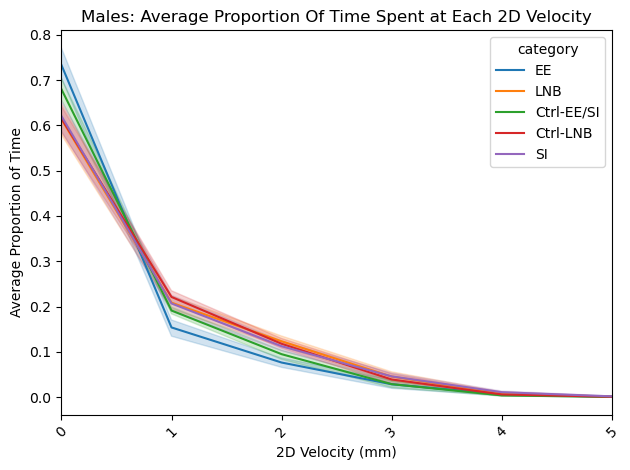

In [44]:
sns.lineplot(data=m_pos_df, x='Metric', y='avg_time', hue='category')
plt.xticks(ticks=range(0, len(m_pos_df['Metric'].unique()), 1))
plt.xlim(0, 5)
plt.title('Males: Average Proportion Of Time Spent at Each 2D Velocity')
plt.xlabel('2D Velocity (mm)')
plt.ylabel('Average Proportion of Time')
plt.xticks(rotation=45)  # Rotate labels if needed
plt.tight_layout()

### Females

In [45]:
f_pos_df = reformat_df(females_df, 'velocity_2d_mm')
f_pos_df = rename_groups(f_pos_df)

In [46]:
save_dir = os.path.join(root, 'Females')

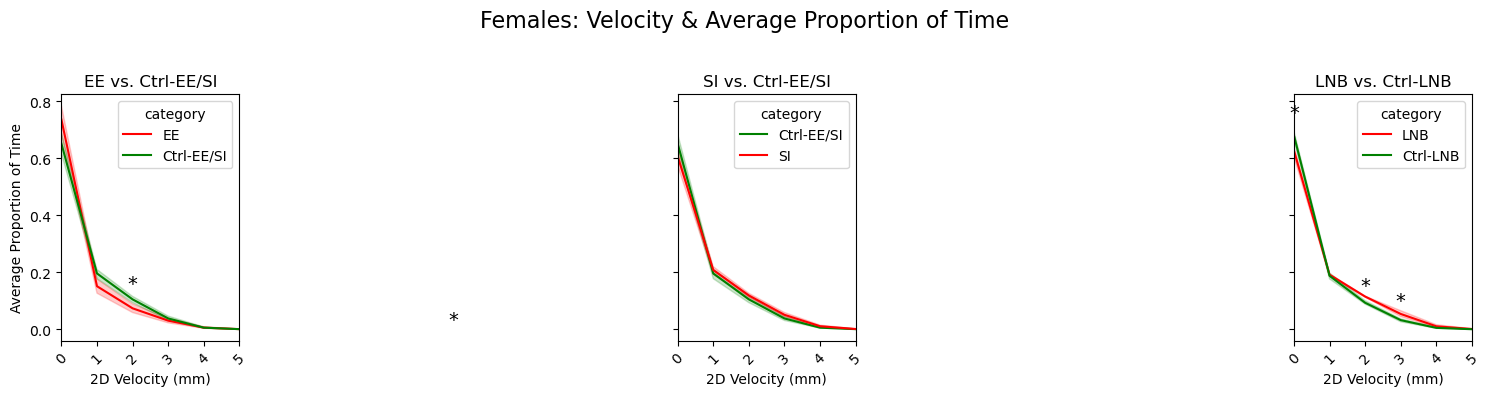

Figure saved to /net/vast-storage/scratch/vast/lhtsai/mabdel03/files/BTI/Moseq/SuperCoolMeeting_I/Figures/Scalars/Velocity/Females/Metric_pairwise.png


In [47]:
pairwise_plots(f_pos_df, ('Metric', 'avg_time'), 'Females: Velocity & Average Proportion of Time', '2D Velocity (mm)', 'Average Proportion of Time', 'mann-whit', [0, 5], save_dir)

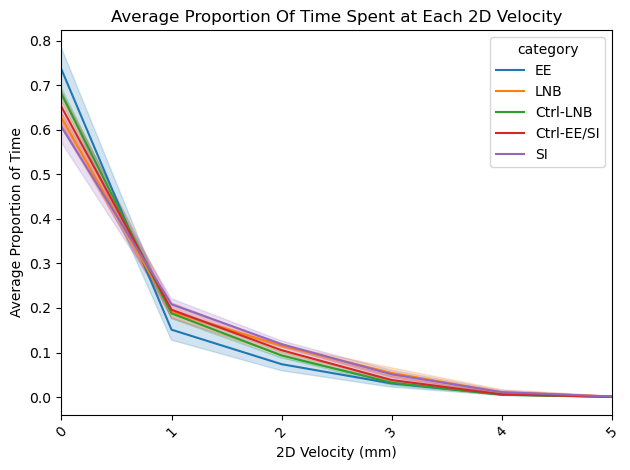

In [48]:
sns.lineplot(data=f_pos_df, x='Metric', y='avg_time', hue='category')
plt.xticks(ticks=range(0, len(f_pos_df['Metric'].unique()), 1))
plt.xlim(0, 5)
plt.title('Average Proportion Of Time Spent at Each 2D Velocity')
plt.xlabel('2D Velocity (mm)')
plt.ylabel('Average Proportion of Time')
plt.xticks(rotation=45)  # Rotate labels if needed
plt.tight_layout()

## Avg Height

In [65]:
root = '/net/vast-storage/scratch/vast/lhtsai/mabdel03/files/BTI/Moseq/SuperCoolMeeting_I/Figures/Scalars/Height'

### Males

In [66]:
m_pos_df = reformat_df(males_df, 'height_ave_mm')
m_pos_df = rename_groups(m_pos_df)

In [67]:
save_dir = os.path.join(root, 'Males')

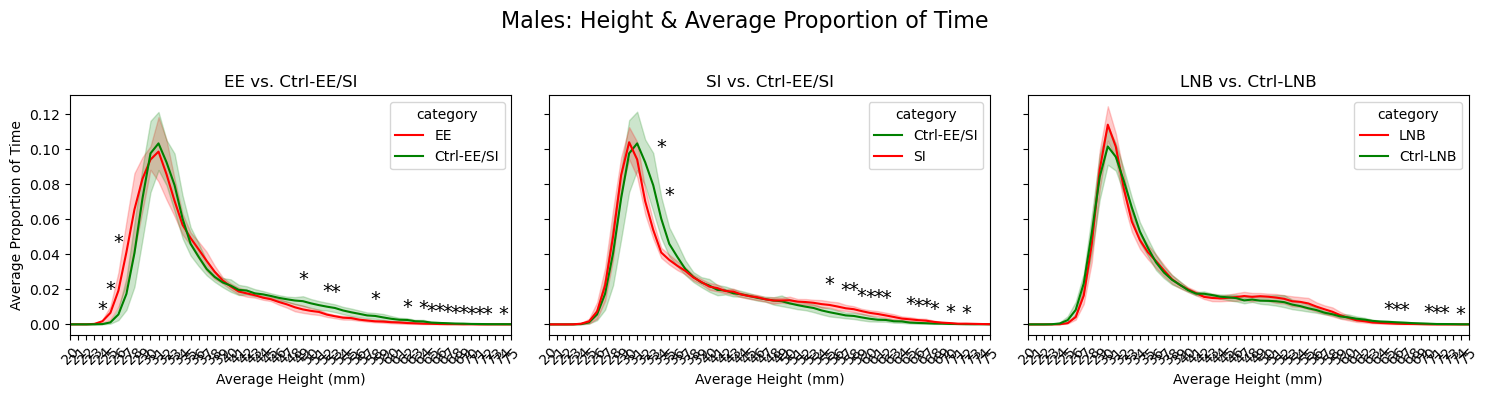

Figure saved to /net/vast-storage/scratch/vast/lhtsai/mabdel03/files/BTI/Moseq/SuperCoolMeeting_I/Figures/Scalars/Height/Males/Metric_pairwise.png


In [68]:
pairwise_plots(m_pos_df, ('Metric', 'avg_time'), 'Males: Height & Average Proportion of Time', 'Average Height (mm)', 'Average Proportion of Time', 'mann-whit', [20, 75], save_dir)

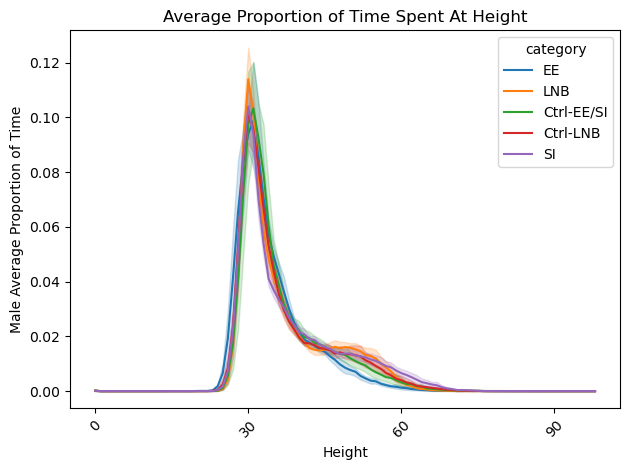

In [69]:
sns.lineplot(data=m_pos_df, x='Metric', y='avg_time', hue='category')
plt.xticks(ticks=range(0, len(m_pos_df['Metric'].unique()), 30))
# Customize the plot
plt.title('Average Proportion of Time Spent At Height')
plt.xlabel('Height')
plt.ylabel('Male Average Proportion of Time')
plt.xticks(rotation=45)  # Rotate labels if needed
plt.tight_layout()

### Females

In [70]:
f_pos_df = reformat_df(females_df, 'height_ave_mm')
f_pos_df = rename_groups(f_pos_df)

In [71]:
save_dir = os.path.join(root, 'Females')

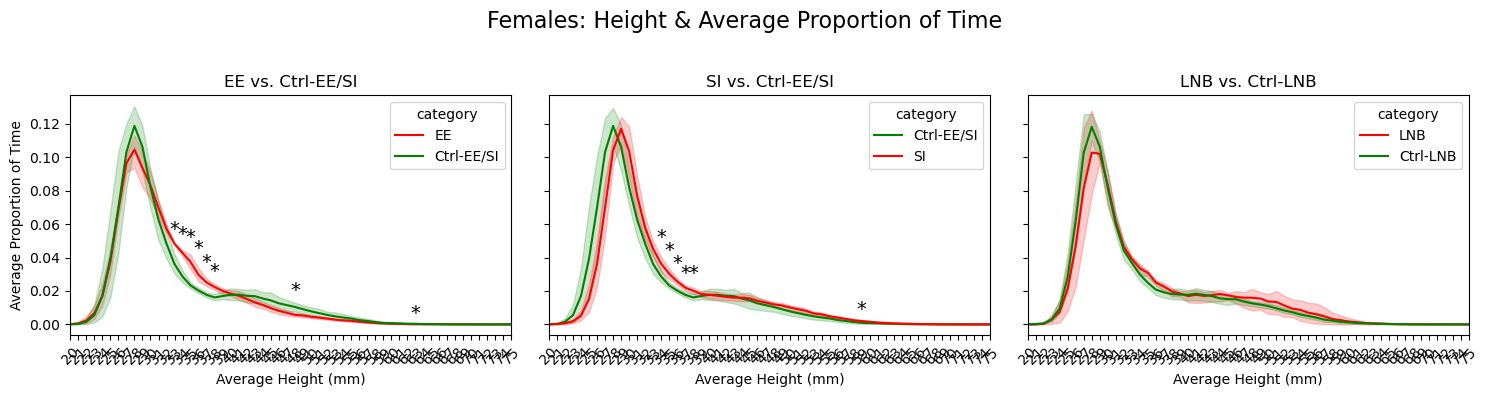

Figure saved to /net/vast-storage/scratch/vast/lhtsai/mabdel03/files/BTI/Moseq/SuperCoolMeeting_I/Figures/Scalars/Height/Females/Metric_pairwise.png


In [72]:
pairwise_plots(f_pos_df, ('Metric', 'avg_time'), 'Females: Height & Average Proportion of Time', 'Average Height (mm)', 'Average Proportion of Time', 'mann-whit', [20, 75], save_dir)

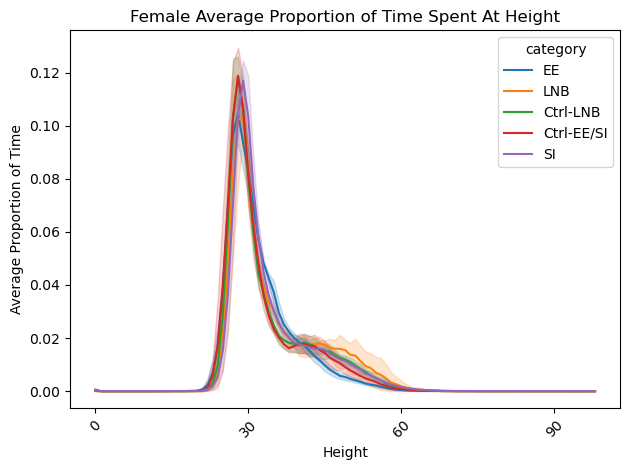

In [73]:
sns.lineplot(data=f_pos_df, x='Metric', y='avg_time', hue='category')
plt.xticks(ticks=range(0, len(f_pos_df['Metric'].unique()), 30))
# Customize the plot
plt.title('Female Average Proportion of Time Spent At Height')
plt.xlabel('Height')
plt.ylabel('Average Proportion of Time')
plt.xticks(rotation=45)  # Rotate labels if needed
plt.tight_layout()

## Length

In [74]:
root = '/net/vast-storage/scratch/vast/lhtsai/mabdel03/files/BTI/Moseq/SuperCoolMeeting_I/Figures/Scalars/Length'

### Males

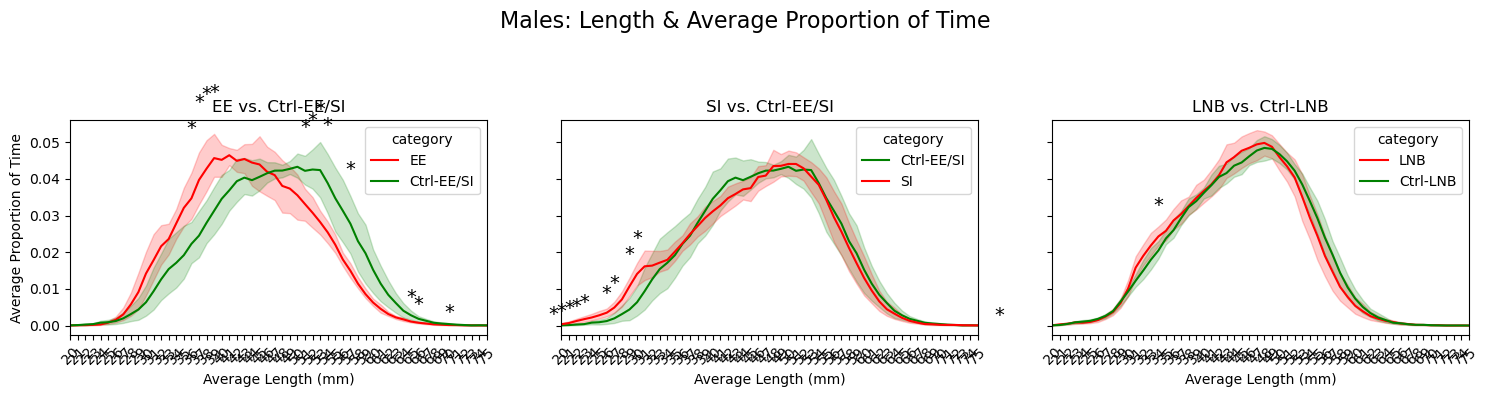

Figure saved to /net/vast-storage/scratch/vast/lhtsai/mabdel03/files/BTI/Moseq/SuperCoolMeeting_I/Figures/Scalars/Length/Males/Metric_pairwise.png


In [75]:
m_pos_df = reformat_df(males_df, 'length_mm')
m_pos_df = rename_groups(m_pos_df)
save_dir = os.path.join(root, 'Males')
pairwise_plots(m_pos_df, ('Metric', 'avg_time'), 'Males: Length & Average Proportion of Time', 'Average Length (mm)', 'Average Proportion of Time', 'mann-whit', [20, 75], save_dir)

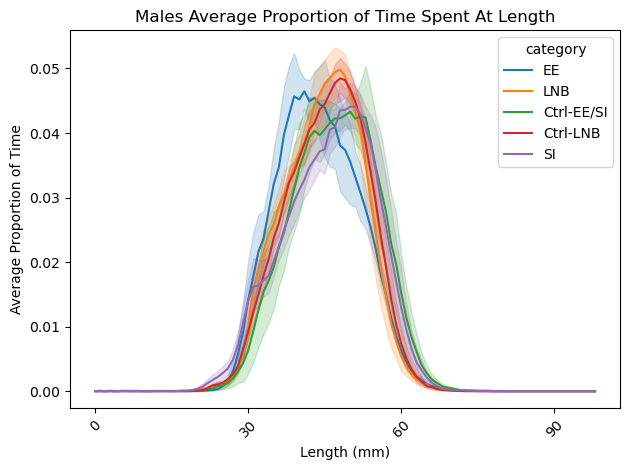

In [76]:
sns.lineplot(data=m_pos_df, x='Metric', y='avg_time', hue='category')
plt.xticks(ticks=range(0, len(m_pos_df['Metric'].unique()), 30))
# Customize the plot
plt.title('Males Average Proportion of Time Spent At Length')
plt.xlabel('Length (mm)')
plt.ylabel('Average Proportion of Time')
plt.xticks(rotation=45)  # Rotate labels if needed
plt.tight_layout()

### Females

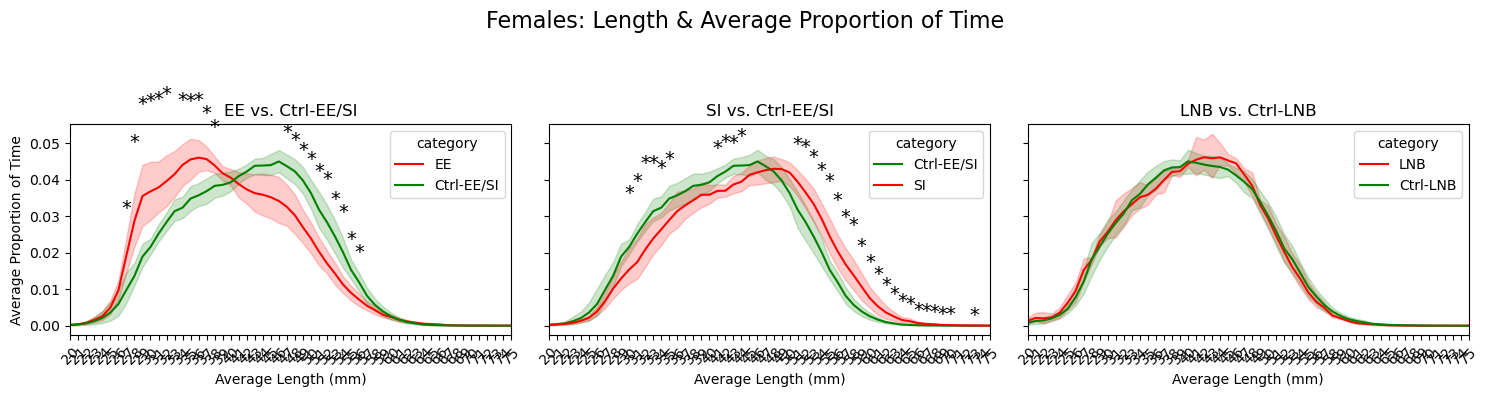

Figure saved to /net/vast-storage/scratch/vast/lhtsai/mabdel03/files/BTI/Moseq/SuperCoolMeeting_I/Figures/Scalars/Length/Females/Metric_pairwise.png


In [77]:
f_pos_df = reformat_df(females_df, 'length_mm')
f_pos_df = rename_groups(f_pos_df)
save_dir = os.path.join(root, 'Females')
pairwise_plots(f_pos_df, ('Metric', 'avg_time'), 'Females: Length & Average Proportion of Time', 'Average Length (mm)', 'Average Proportion of Time', 'mann-whit', [20, 75], save_dir)

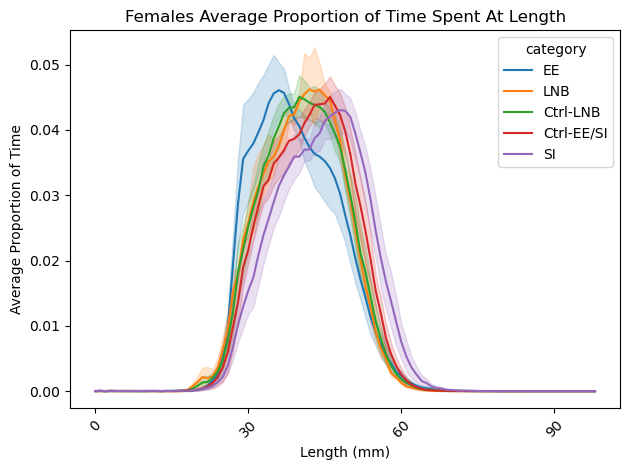

In [78]:
sns.lineplot(data=f_pos_df, x='Metric', y='avg_time', hue='category')
plt.xticks(ticks=range(0, len(f_pos_df['Metric'].unique()), 30))
# Customize the plot
plt.title('Females Average Proportion of Time Spent At Length')
plt.xlabel('Length (mm)')
plt.ylabel('Average Proportion of Time')
plt.xticks(rotation=45)  # Rotate labels if needed
plt.tight_layout()

## Moseq

### Males

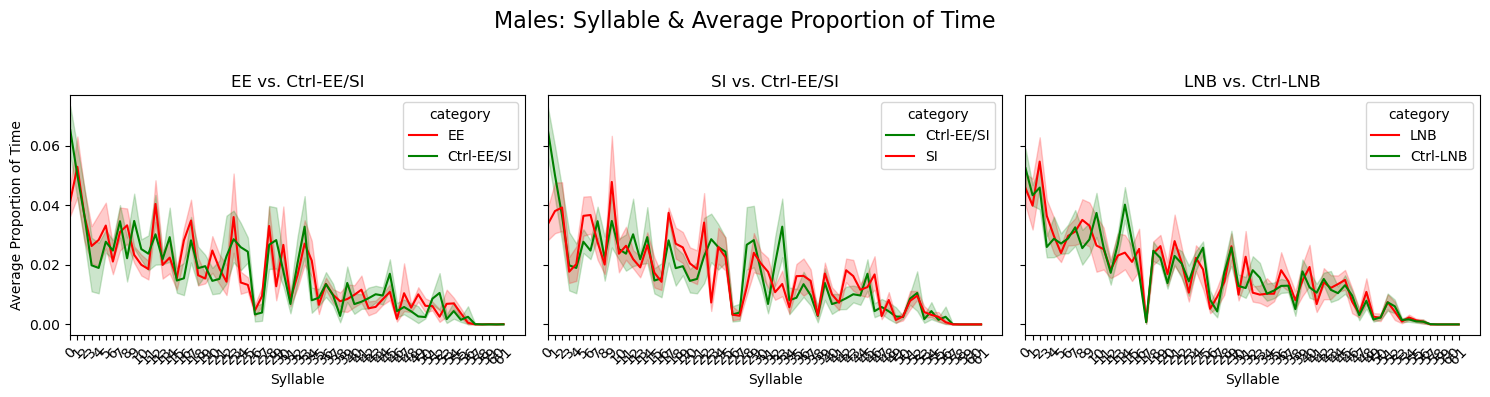

Figure saved to /om2/user/mabdel03/files/BTI/Metric_pairwise.png


In [79]:
m_pos_df = reformat_df(males_df, 'MoSeq')
m_pos_df = rename_groups(m_pos_df)
pairwise_plots(m_pos_df, ('Metric', 'avg_time'), 'Males: Syllable & Average Proportion of Time', 'Syllable', 'Average Proportion of Time', 'NA', [0, 64])

### Females

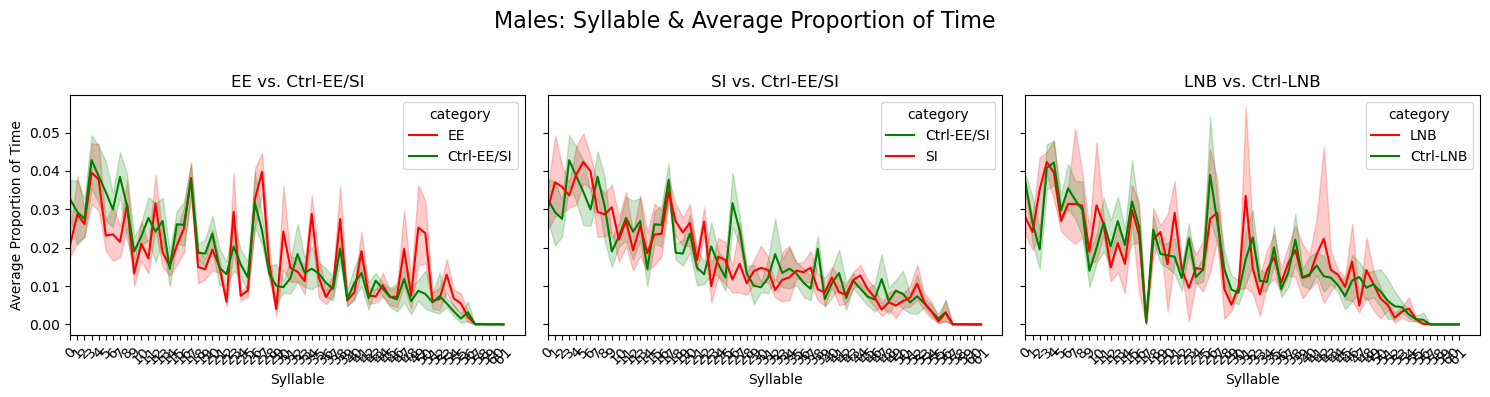

Figure saved to /om2/user/mabdel03/files/BTI/Metric_pairwise.png


In [80]:
f_pos_df = reformat_df(females_df, 'MoSeq')
f_pos_df = rename_groups(f_pos_df)
pairwise_plots(f_pos_df, ('Metric', 'avg_time'), 'Males: Syllable & Average Proportion of Time', 'Syllable', 'Average Proportion of Time', 'NA', [0, 64])

# Transition Matrix Analysis

## Assembling The Matrices From CSVs

In [2]:
import numpy as np

In [3]:
root = '/om/scratch/Sun/mabdel03/Moseq/Redo_3/moseq_data/models/model-014-8858668'

In [4]:
from os.path import join

In [5]:
paths = {
    'LNB_Male': join(root, 'LNB_Normal_Male_rows_transition_matrix.csv'),
    'LNB_Female': join(root, 'LNB_Normal_Female_rows_transition_matrix.csv'),
    'SI_Male': join(root, 'SI_Normal_Male_rows_transition_matrix.csv'),
    'SI_Female': join(root, 'SI_Normal_Female_rows_transition_matrix.csv'),
    'SI_Male': join(root, 'SI_Normal_Male_rows_transition_matrix.csv'),
    'EE_Male': join(root, 'EE_Normal_Male_rows_transition_matrix.csv'), 
    'EE_Female': join(root, 'EE_Normal_Female_rows_transition_matrix.csv'),
    'Ctrl_Male': join(root, 'NGH_Normal_Male_rows_transition_matrix.csv'),
    'Ctrl_Female': join(root, 'NGH_Normal_Female_rows_transition_matrix.csv'),                  
}

In [6]:
matrices = {}
for name, path in paths.items():
    matrices[name] = np.genfromtxt(path, delimiter=',', skip_header=1)

males = {key.split('_')[0]: value for key, value in matrices.items() if key.endswith('Male')}
females = {key.split('_')[0]: value for key, value in matrices.items() if key.endswith('Female')}

In [7]:
comparisons = [('LNB', 'Ctrl'), ('EE', 'Ctrl'), ('SI', 'Ctrl'), ('EE', 'SI'), ('EE', 'LNB')]

## Visualizations

### Males

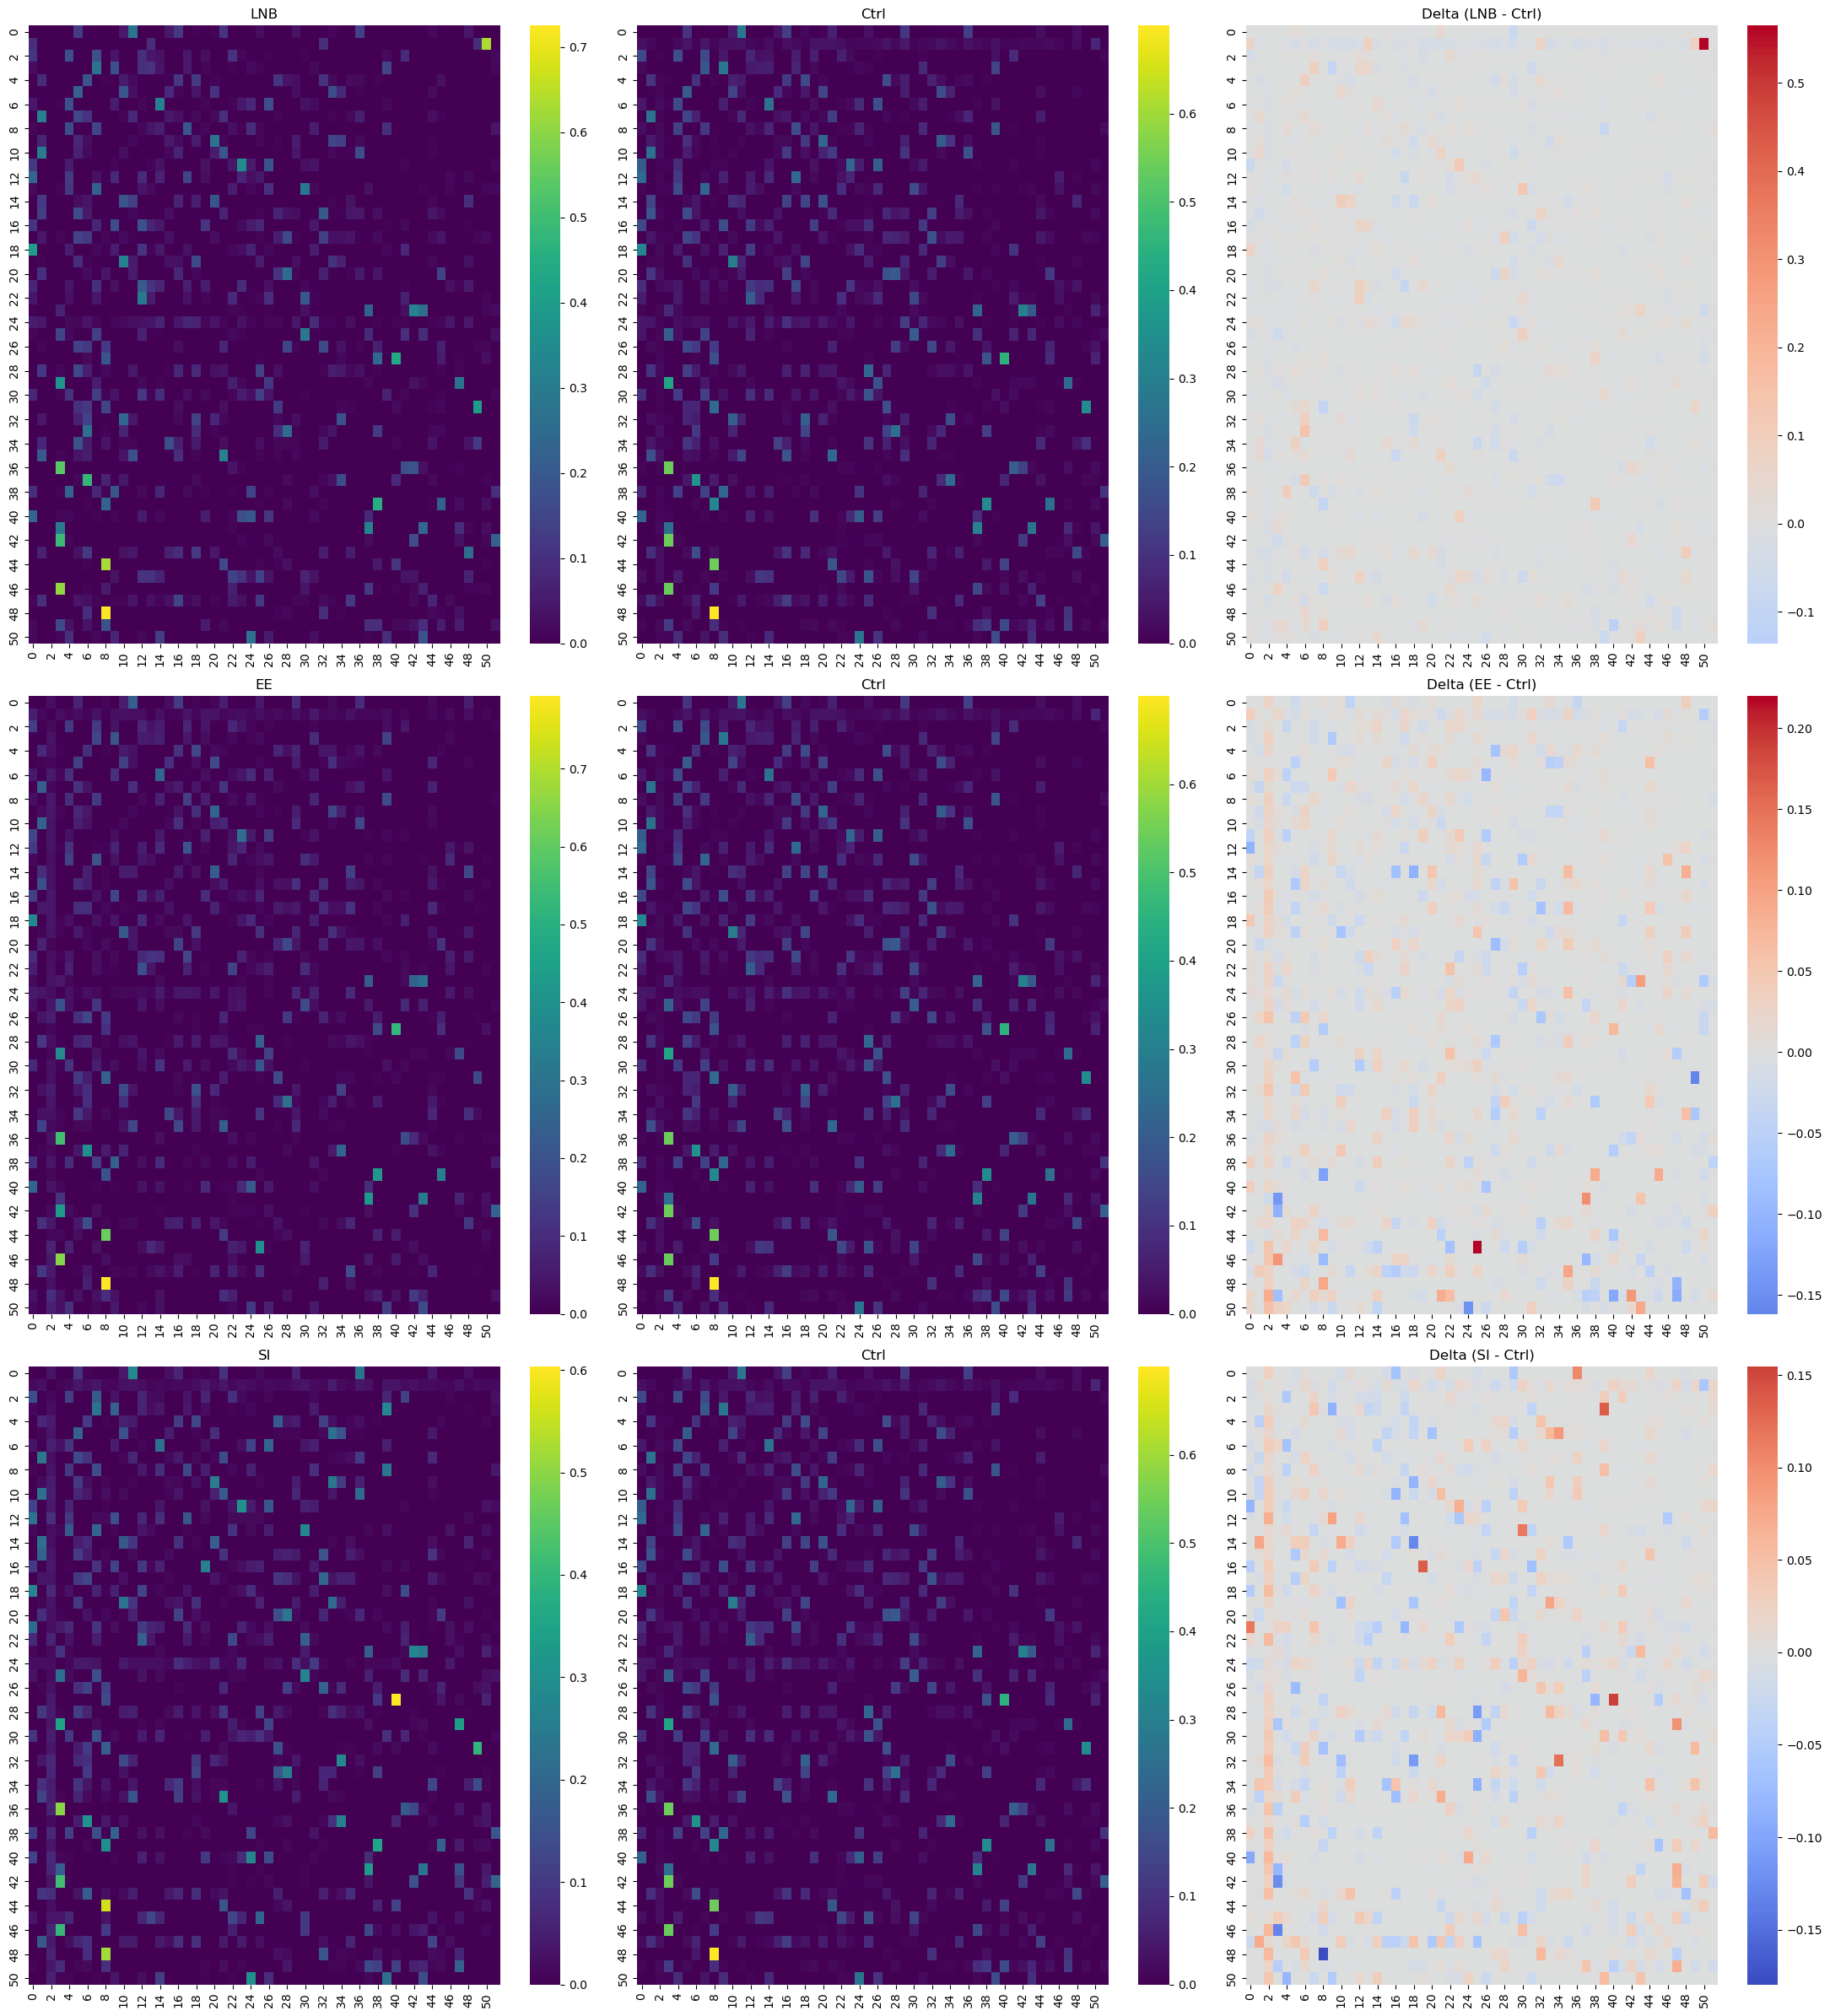

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Your specific comparisons list
comparisons = [('LNB', 'Ctrl'), ('EE', 'Ctrl'), ('SI', 'Ctrl'), ('EE', 'SI'), ('EE', 'LNB')]

# Split the comparisons into two groups
comparisons_group1 = comparisons[:3]  # First 3 comparisons
comparisons_group2 = comparisons[3:]   # Last 2 comparisons

def plot_comparisons(comparisons, panel_name):
    n_comparisons = len(comparisons)

    # Create a figure with 3 columns and n_comparisons rows
    fig, axes = plt.subplots(n_comparisons, 3, figsize=(22, 8 * n_comparisons))

    # If there's only one comparison, adjust axes for single row case
    if n_comparisons == 1:
        axes = np.expand_dims(axes, axis=0)

    for i, (mat1, mat2) in enumerate(comparisons):
        matrix1 = males[mat1]
        matrix2 = males[mat2]

        # Compute the difference (delta) matrix
        delta_matrix = matrix1 - matrix2

        # Plot the matrices side by side and the delta matrix
        sns.heatmap(matrix1, ax=axes[i, 0], cmap="viridis")
        axes[i, 0].set_title(mat1)

        sns.heatmap(matrix2, ax=axes[i, 1], cmap="viridis")
        axes[i, 1].set_title(mat2)

        sns.heatmap(delta_matrix, ax=axes[i, 2], cmap="coolwarm", center=0)
        axes[i, 2].set_title(f'Delta ({mat1} - {mat2})')

    # Adjust layout to avoid overlapping titles and labels
    plt.tight_layout()

    # Save the figure as a PNG if needed
    plt.savefig(f"{panel_name}.png")

    plt.show()

# Plot the first group of comparisons
plot_comparisons(comparisons_group1, "comparison_panel_1")


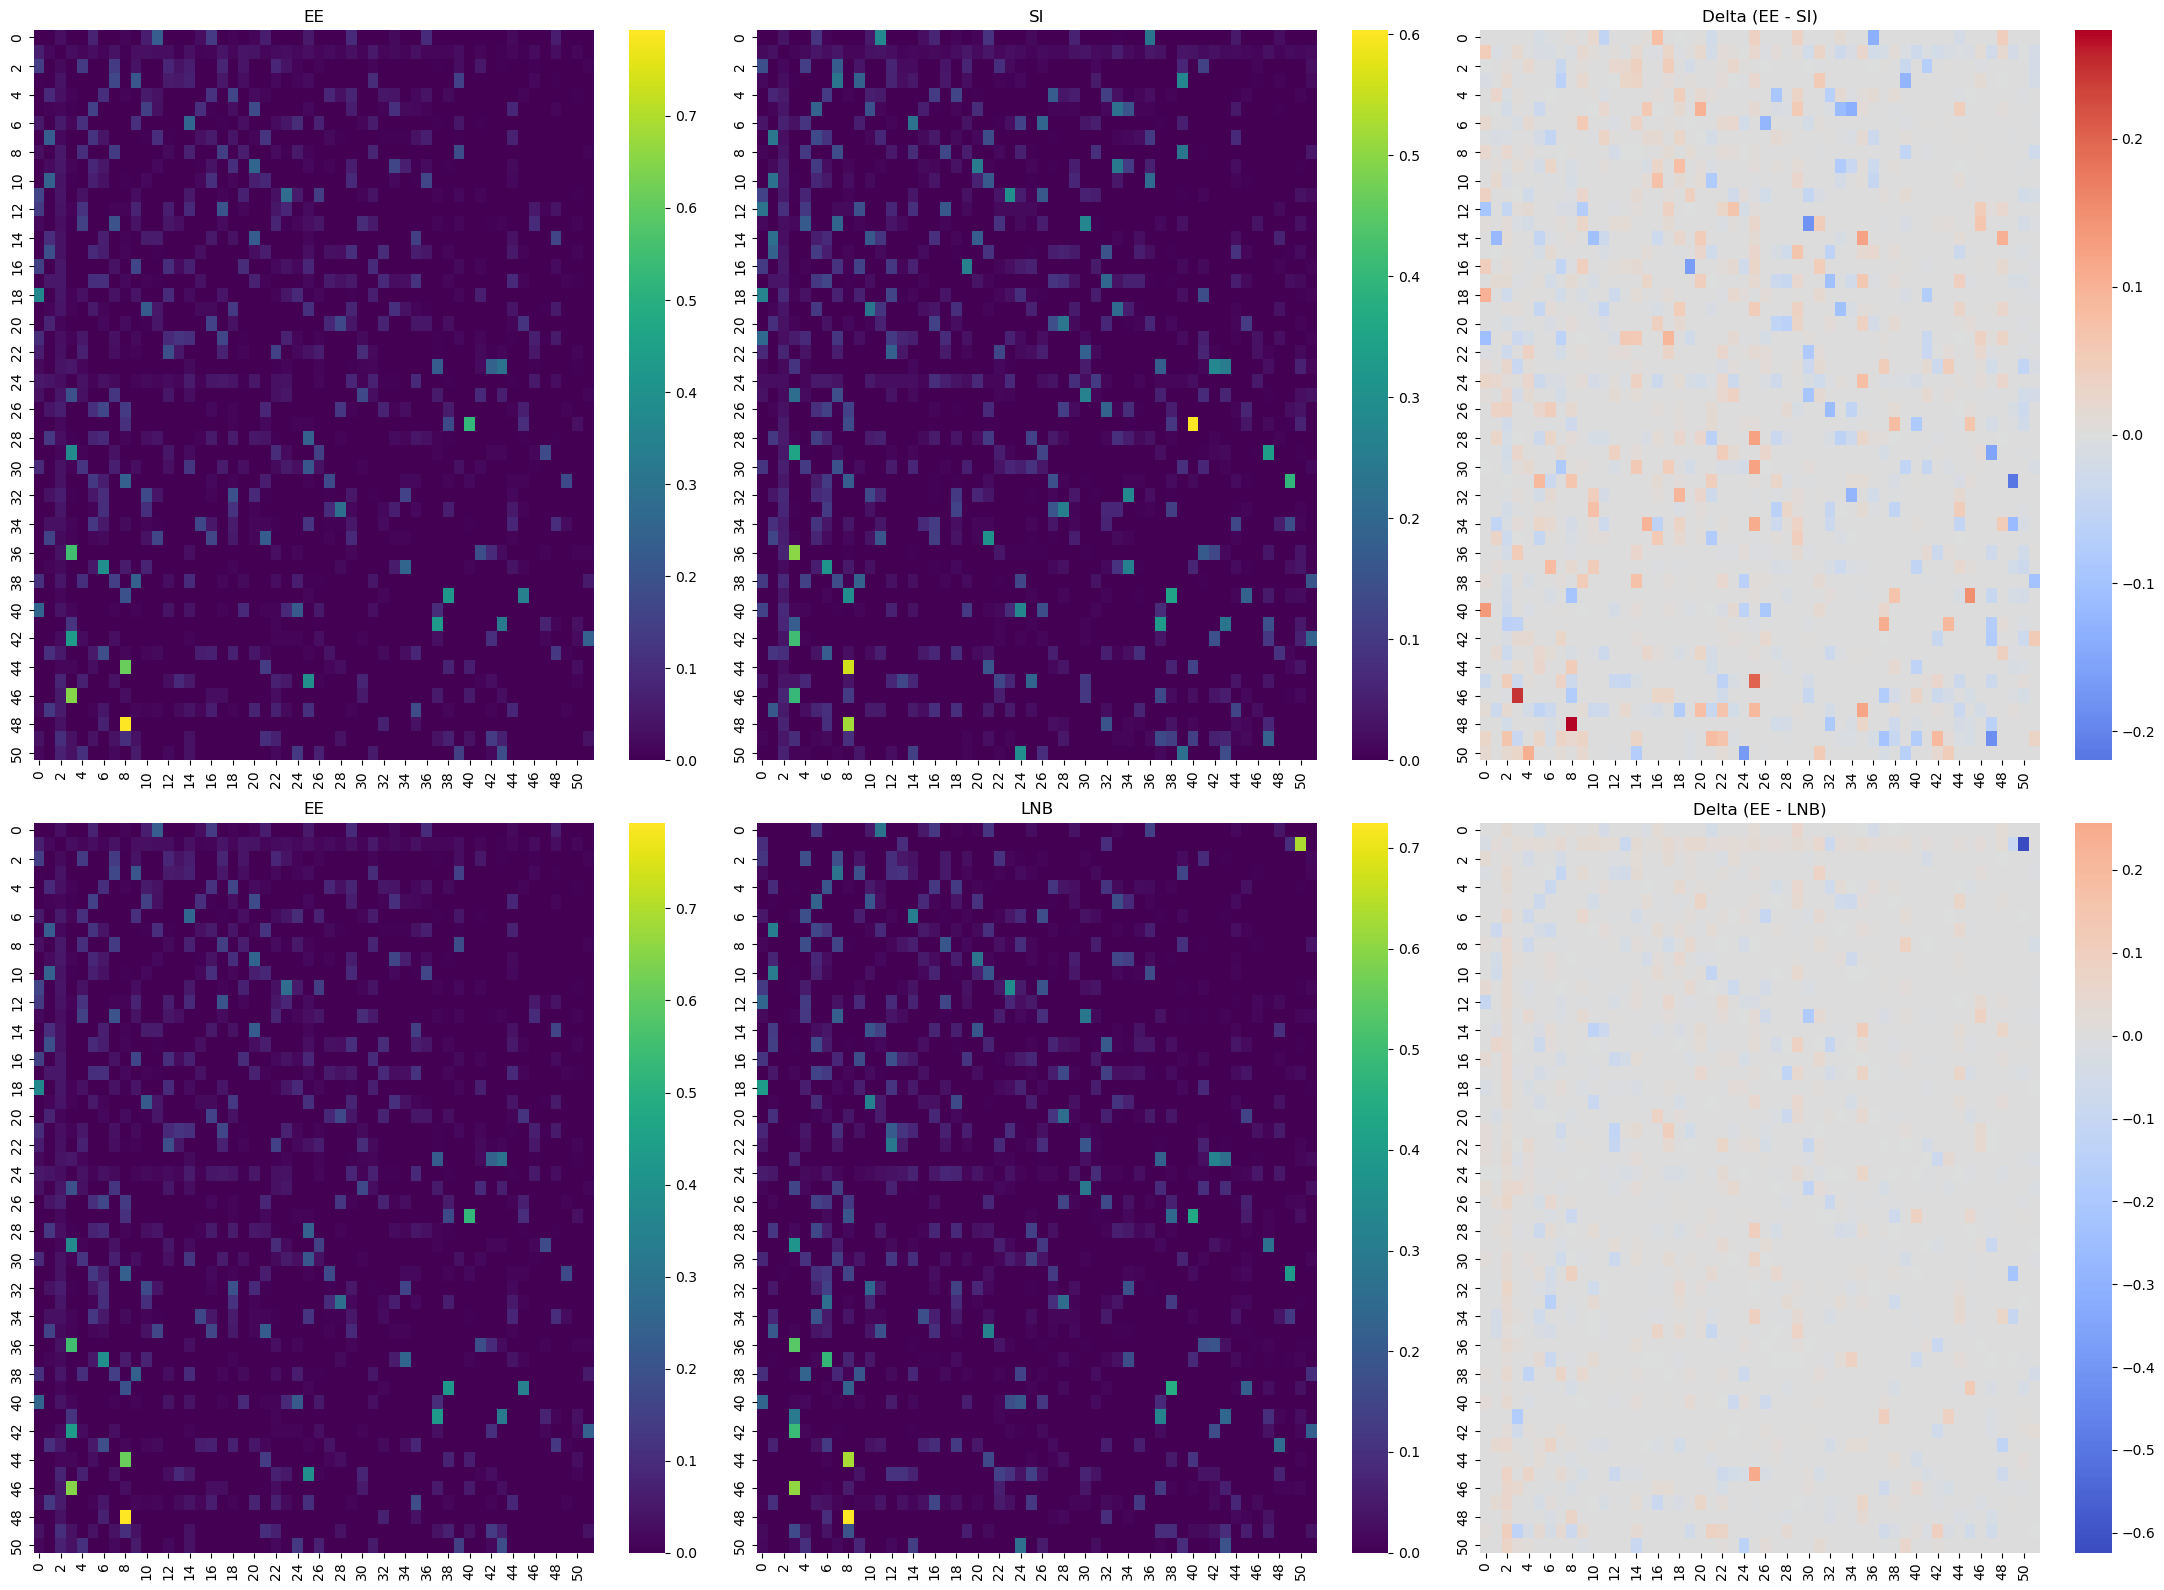

In [11]:
# Plot the second group of comparisons
plot_comparisons(comparisons_group2, "comparison_panel_2")

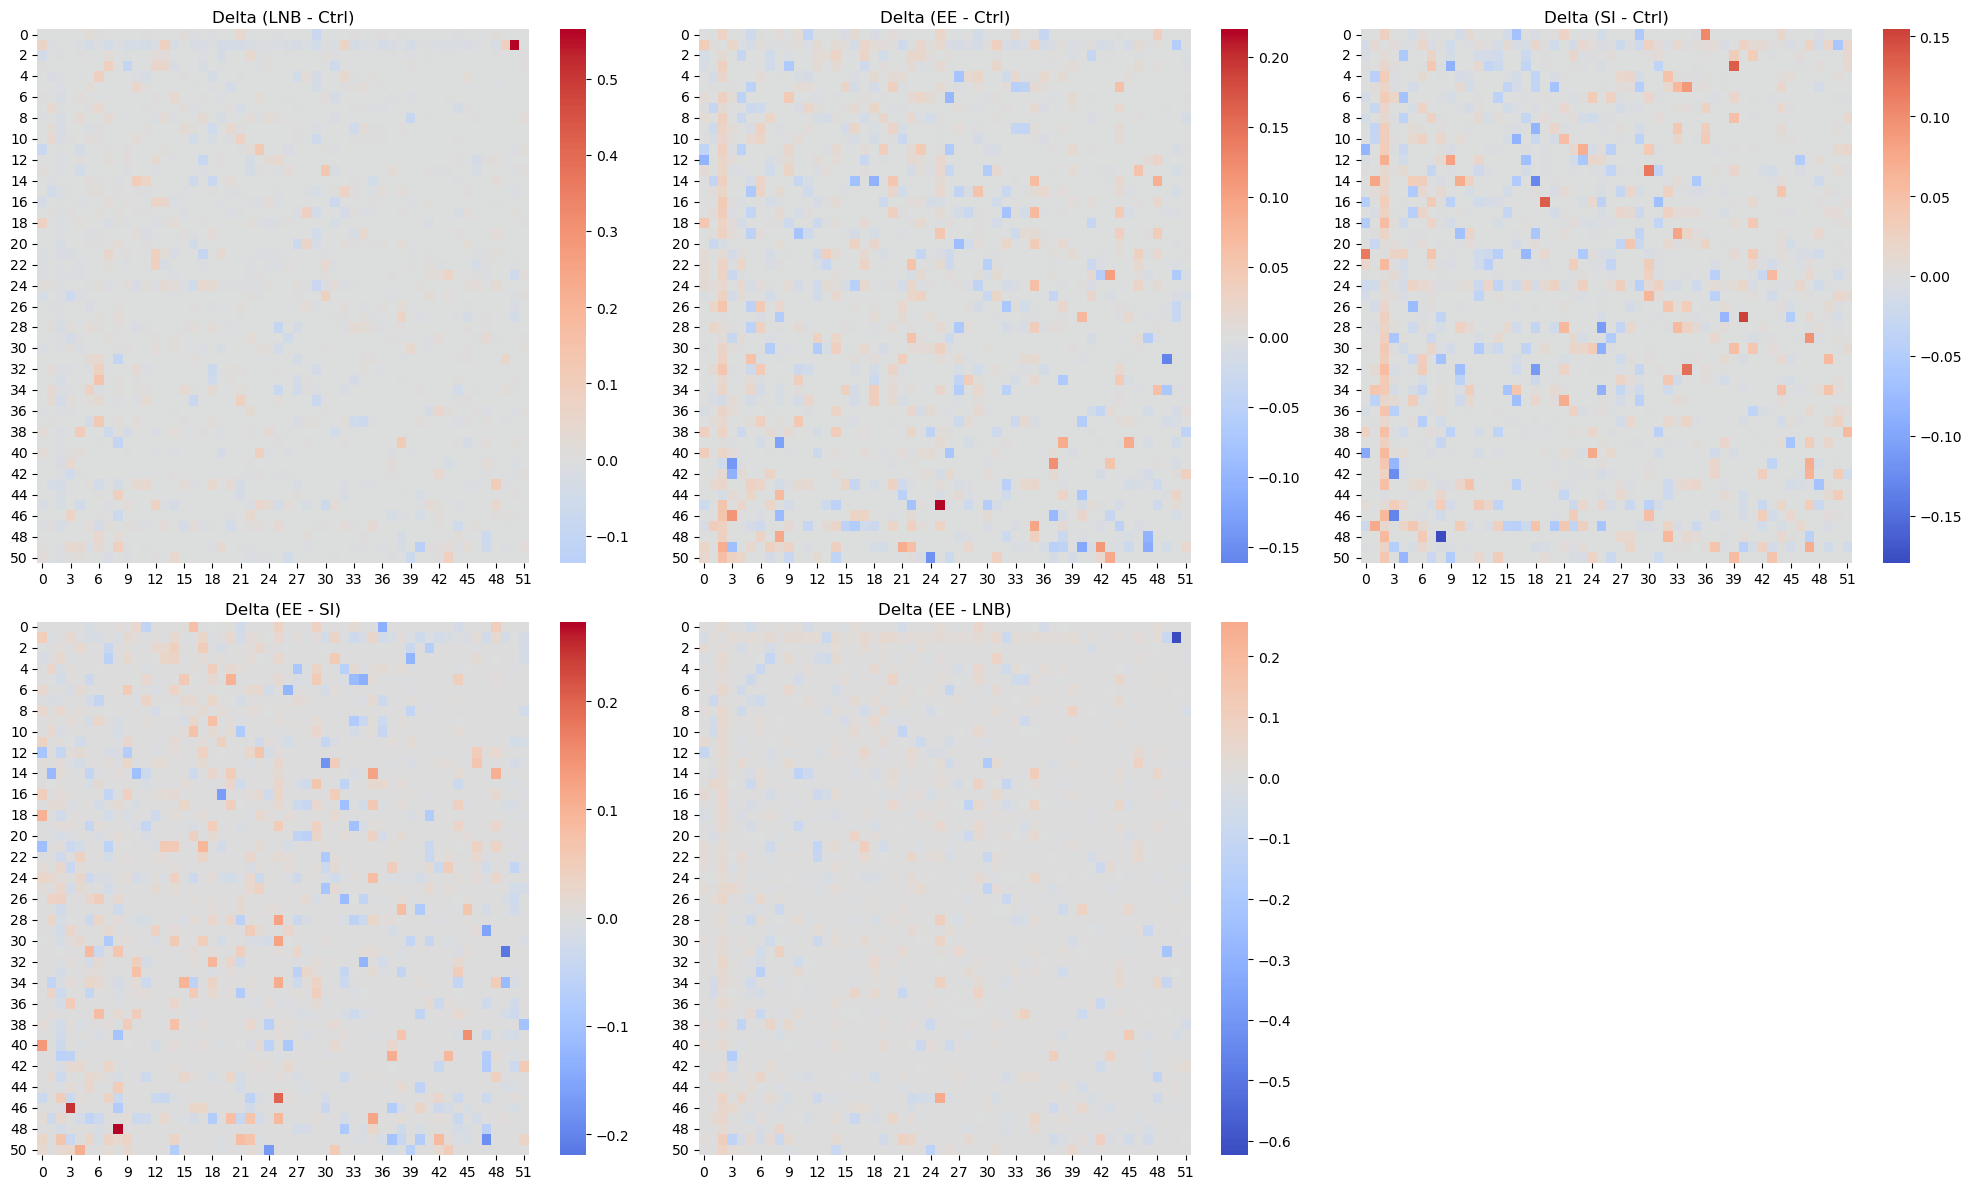

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Your specific comparisons list
comparisons = [('LNB', 'Ctrl'), ('EE', 'Ctrl'), ('SI', 'Ctrl'), ('EE', 'SI'), ('EE', 'LNB')]

# Determine the number of comparisons
n_comparisons = len(comparisons)

# Calculate grid dimensions (e.g., 2 rows and 3 columns for 5 comparisons)
rows = 2
cols = 3  # One extra column for padding or use 2x3 grid depending on layout preference

# Create a figure with a grid to fit all delta plots
fig, axes = plt.subplots(rows, cols, figsize=(20, 12))

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, (mat1, mat2) in enumerate(comparisons):
    matrix1 = males[mat1]
    matrix2 = males[mat2]

    # Compute the difference (delta) matrix
    delta_matrix = matrix1 - matrix2

    # Plot the delta matrix
    sns.heatmap(delta_matrix, ax=axes[i], cmap="coolwarm", center=0)
    axes[i].set_title(f'Delta ({mat1} - {mat2})')

# Hide any unused subplots (if cols*rows > n_comparisons)
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to make sure plots fit nicely
plt.tight_layout()

# Save the figure as a PNG suitable for Google Slides
plt.savefig("delta_comparison_panel_for_slide.png", dpi=300)

plt.show()


### Females

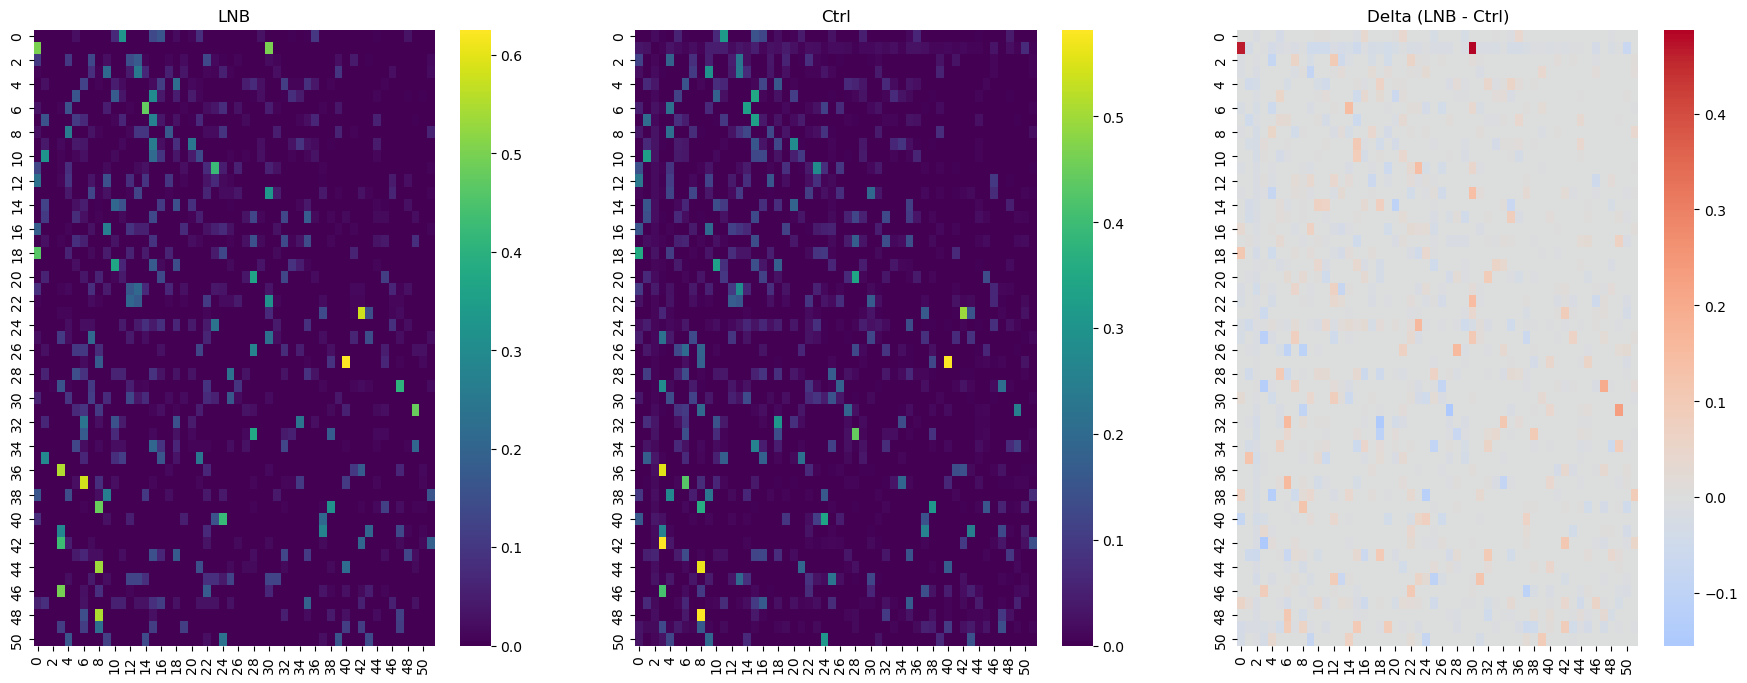

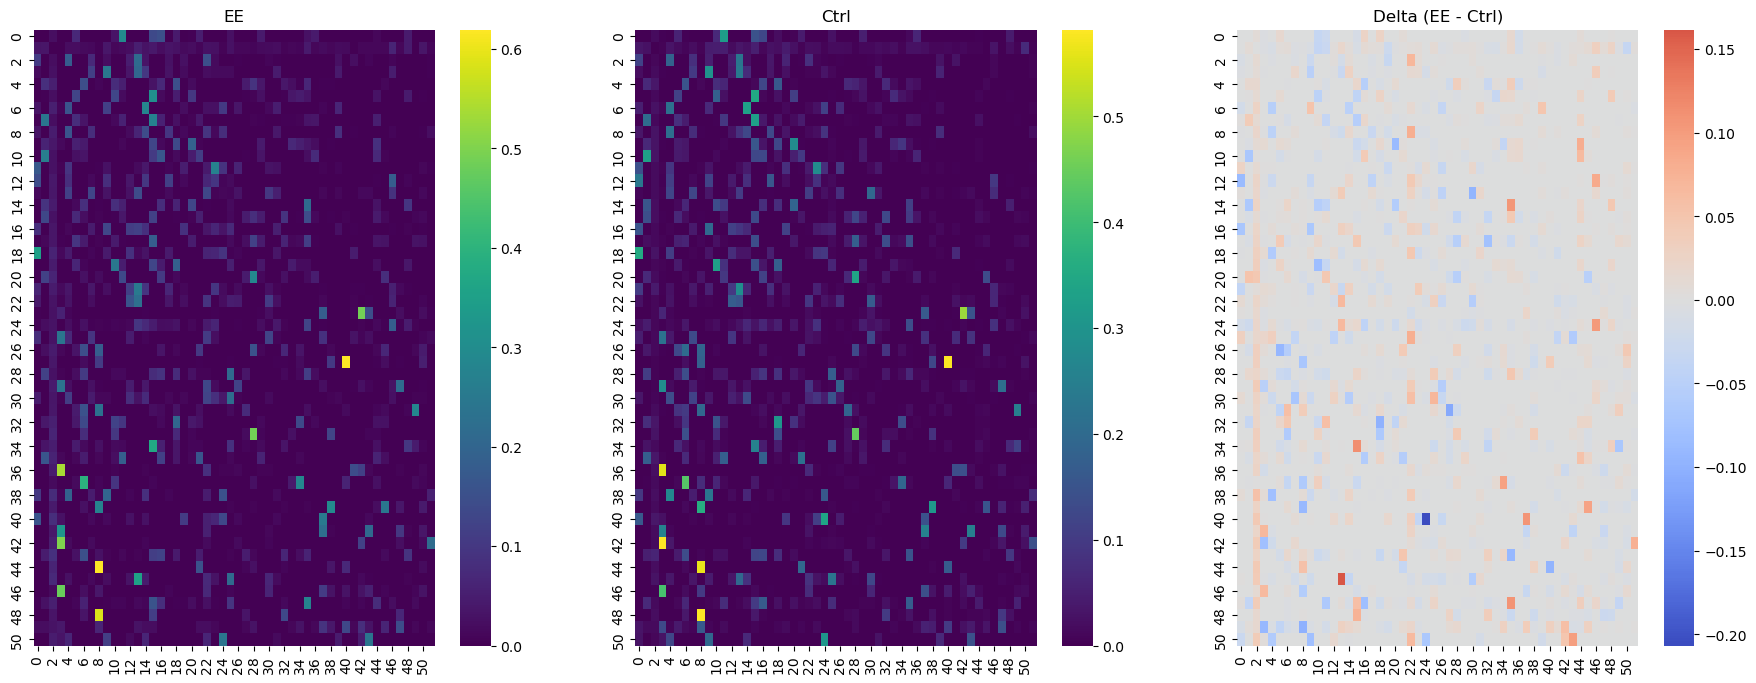

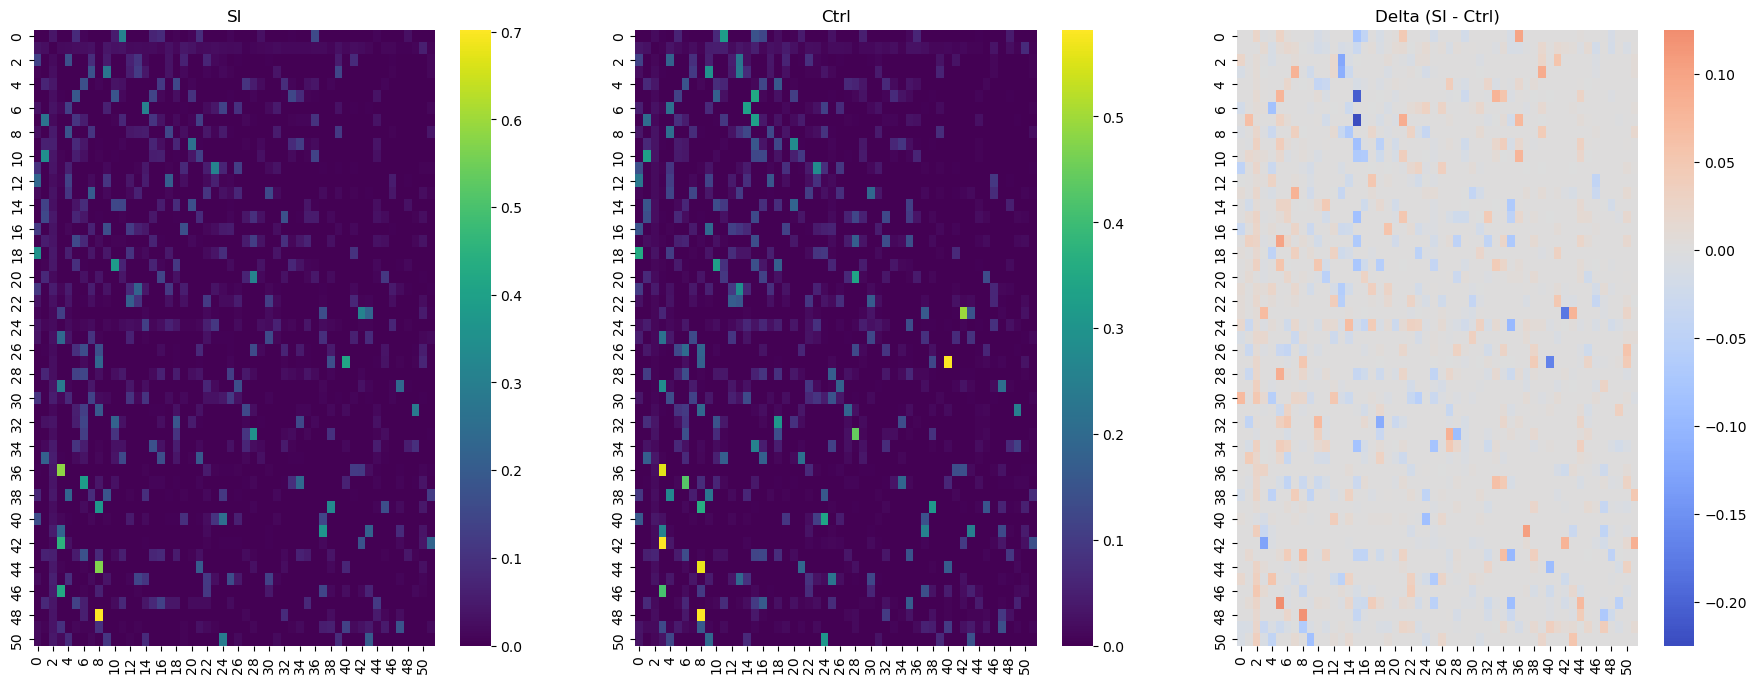

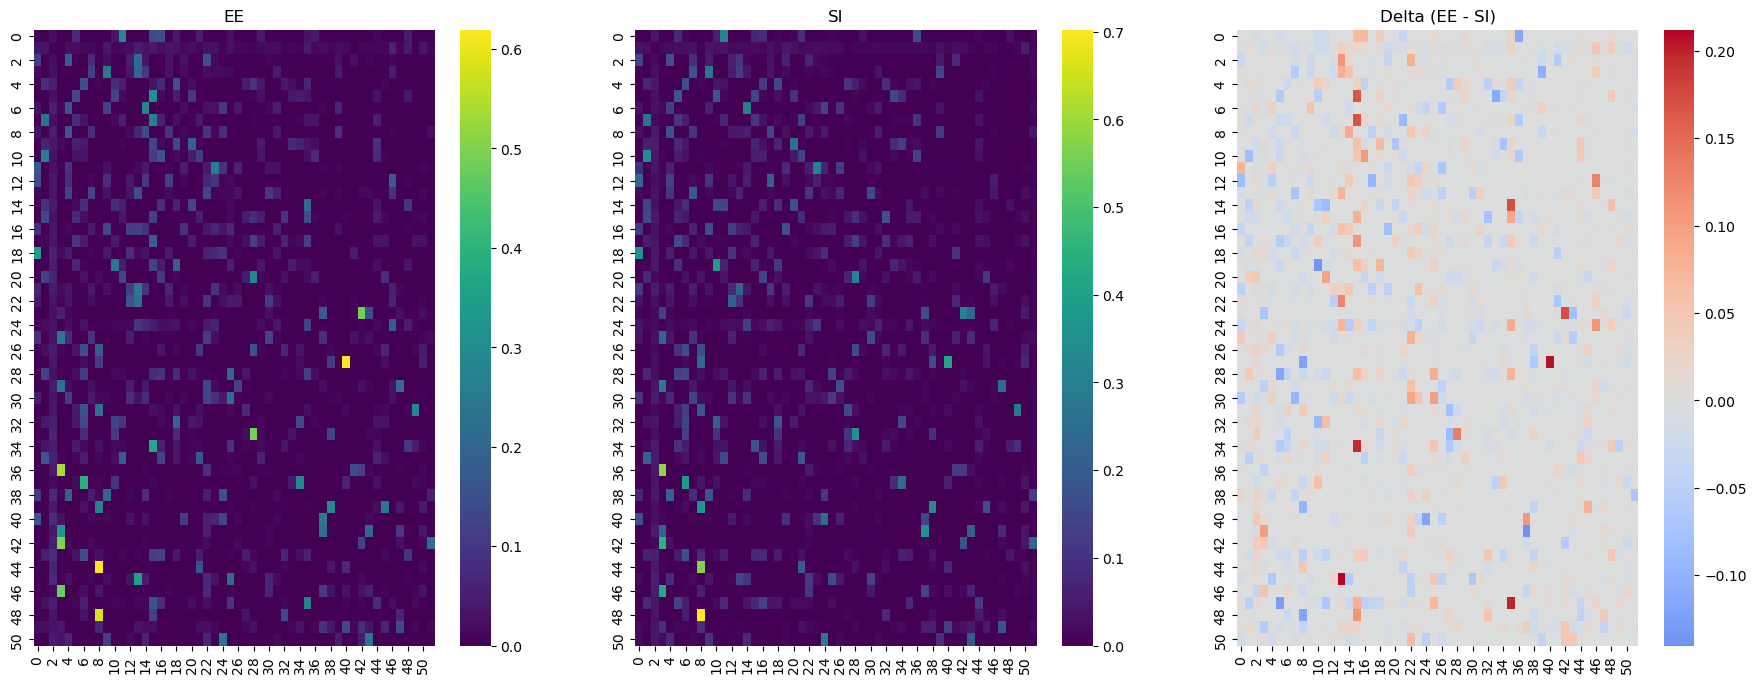

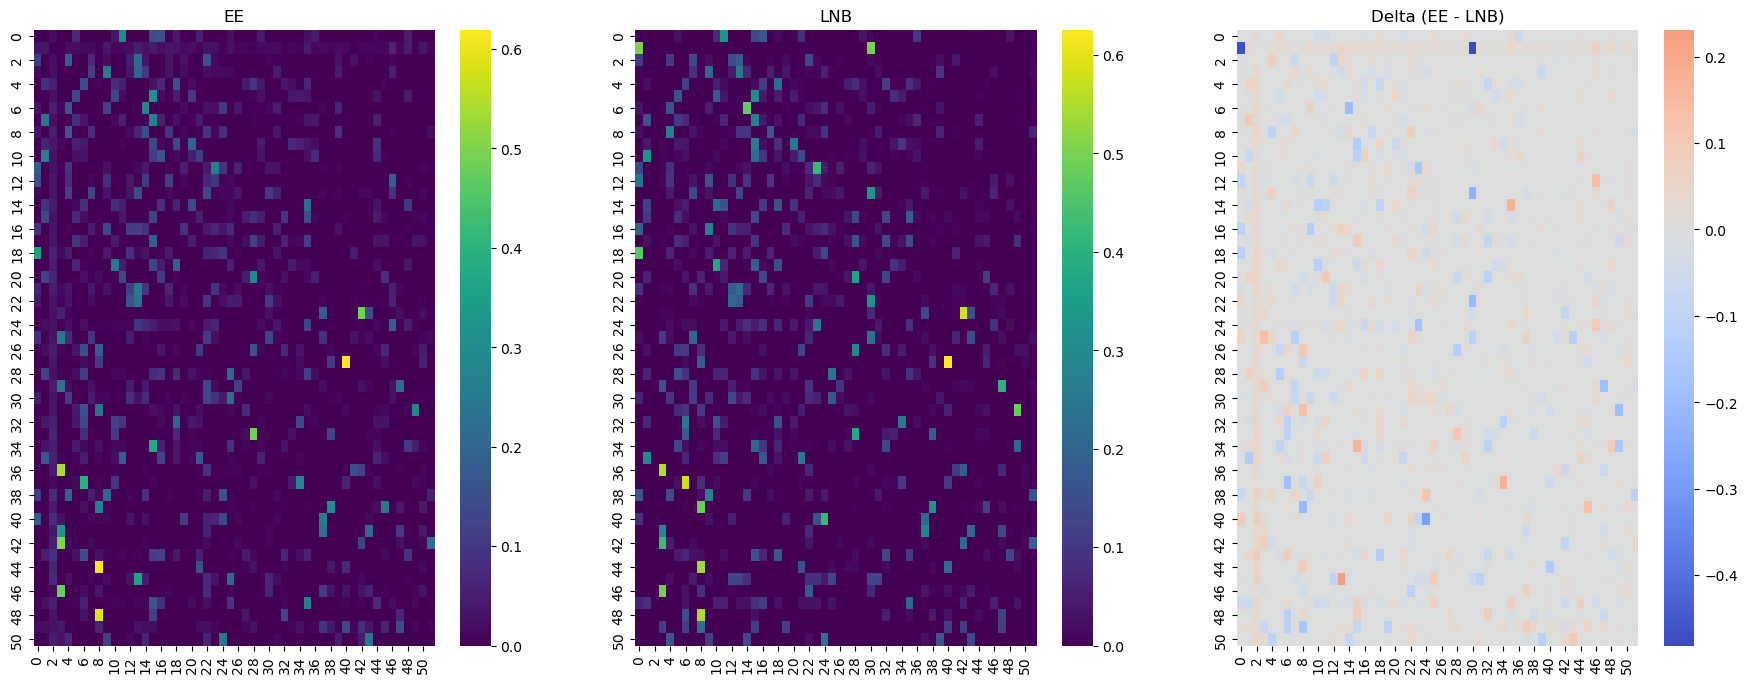

In [130]:
for mat1, mat2 in comparisons:

    matrix1 = females[mat1]
    matrix2 = females[mat2]

    # Compute the difference (delta) matrix
    delta_matrix = matrix1 - matrix2
    
    # Plot the matrices side by side and the delta matrix
    fig, axes = plt.subplots(1, 3, figsize=(22, 8))
    
    sns.heatmap(matrix1, ax=axes[0], cmap="viridis")
    axes[0].set_title(mat1)
    
    sns.heatmap(matrix2, ax=axes[1], cmap="viridis")
    axes[1].set_title(mat2)
    
    sns.heatmap(delta_matrix, ax=axes[2], cmap="coolwarm", center=0)
    axes[2].set_title(f'Delta ({mat1} - {mat2})')
    
    plt.show()

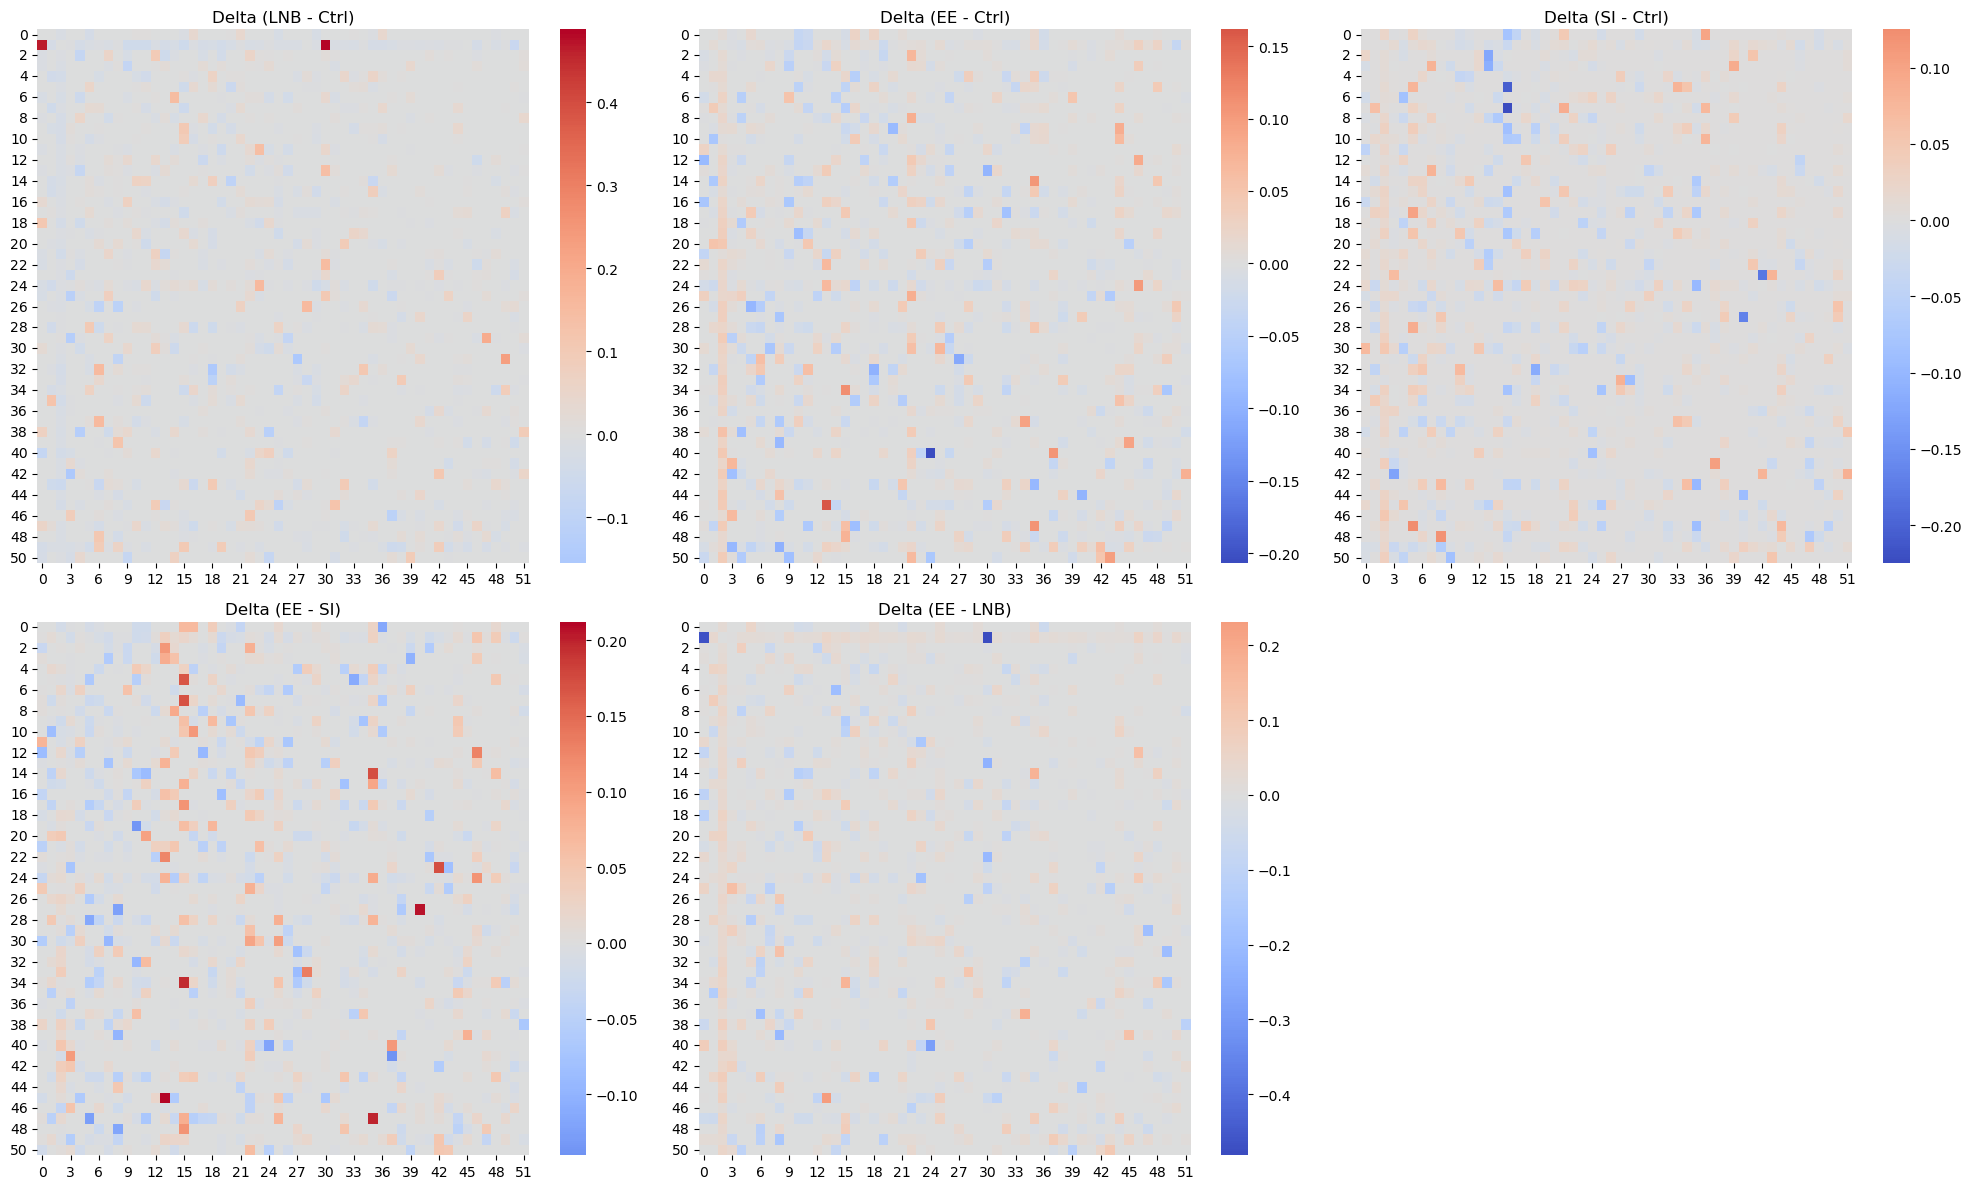

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Your specific comparisons list
comparisons = [('LNB', 'Ctrl'), ('EE', 'Ctrl'), ('SI', 'Ctrl'), ('EE', 'SI'), ('EE', 'LNB')]

# Determine the number of comparisons
n_comparisons = len(comparisons)

# Calculate grid dimensions (e.g., 2 rows and 3 columns for 5 comparisons)
rows = 2
cols = 3  # One extra column for padding or use 2x3 grid depending on layout preference

# Create a figure with a grid to fit all delta plots
fig, axes = plt.subplots(rows, cols, figsize=(20, 12))

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, (mat1, mat2) in enumerate(comparisons):
    matrix1 = females[mat1]
    matrix2 = females[mat2]

    # Compute the difference (delta) matrix
    delta_matrix = matrix1 - matrix2

    # Plot the delta matrix
    sns.heatmap(delta_matrix, ax=axes[i], cmap="coolwarm", center=0)
    axes[i].set_title(f'Delta ({mat1} - {mat2})')

# Hide any unused subplots (if cols*rows > n_comparisons)
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to make sure plots fit nicely
plt.tight_layout()

# Save the figure as a PNG suitable for Google Slides
plt.savefig("delta_comparison_panel_for_slide.png", dpi=300)

plt.show()


## Statistical Significance Testing

### Mantel Test Approach

In [141]:
import numpy as np
from scipy.spatial import distance_matrix
from scipy.stats import pearsonr
from sklearn.utils import resample

def mantel_test(matrix1, matrix2, num_permutations=1000):
    """
    Perform a Mantel test to assess the correlation between two distance matrices.

    Parameters:
    - matrix1: First distance matrix
    - matrix2: Second distance matrix
    - num_permutations: Number of permutations for the test

    Returns:
    - observed_corr: The observed correlation between the two matrices
    - p_value: The p-value for the test
    """
    # Flatten the upper triangles of both matrices
    idx = np.triu_indices_from(matrix1, k=1)
    matrix1_flat = matrix1[idx]
    matrix2_flat = matrix2[idx]

    # Calculate the observed Pearson correlation
    observed_corr, _ = pearsonr(matrix1_flat, matrix2_flat)

    # Permutation test
    permuted_corrs = []
    for _ in range(num_permutations):
        matrix2_permuted = resample(matrix2_flat)
        permuted_corr, _ = pearsonr(matrix1_flat, matrix2_permuted)
        permuted_corrs.append(permuted_corr)

    # Calculate p-value
    permuted_corrs = np.array(permuted_corrs)
    p_value = np.mean(permuted_corrs >= observed_corr)

    return observed_corr, p_value

In [142]:
for mat1, mat2 in comparisons:

    A = females[mat1]
    B = females[mat2]
    distance_matrix_A = distance_matrix(A, A)
    distance_matrix_B = distance_matrix(B, B)
    # Perform Mantel test
    observed_corr, p_value = mantel_test(distance_matrix_A, distance_matrix_B)
    
    print(f"Observed correlation: {observed_corr}")
    print(f"P-value: {p_value}")

Observed correlation: 0.7549170272144199
P-value: 0.0
Observed correlation: 0.9526050615624096
P-value: 0.0
Observed correlation: 0.9340639719276733
P-value: 0.0
Observed correlation: 0.8989712654072466
P-value: 0.0
Observed correlation: 0.7236380618433387
P-value: 0.0


### Frobenius Norm + Permutations Test Approach

In [138]:
# Calculate Frobenius norm between two matrices
def frobenius_norm(A, B):
    return np.linalg.norm(A - B, 'fro')

# Permutation test to assess significance
def permutation_test(A, B, num_permutations=100000):
    observed_norm = frobenius_norm(A, B)
    permuted_norms = []

    for _ in range(num_permutations):
        # Permute matrix A
        permuted_A = np.random.permutation(A.flatten()).reshape(A.shape)
        permuted_norm = frobenius_norm(permuted_A, B)
        permuted_norms.append(permuted_norm)

    # Calculate p-value
    permuted_norms = np.array(permuted_norms)
    p_value = np.mean(permuted_norms >= observed_norm)

    return observed_norm, p_value

"""
# Example matrices
A = np.array([[1, 2], [3, 4]])
B = np.array([[4, 3], [2, 1]])

observed_norm, p_value = permutation_test(A, B)
print(f"Observed Frobenius norm: {observed_norm}")
print(f"p-value: {p_value}")
"""

'\n# Example matrices\nA = np.array([[1, 2], [3, 4]])\nB = np.array([[4, 3], [2, 1]])\n\nobserved_norm, p_value = permutation_test(A, B)\nprint(f"Observed Frobenius norm: {observed_norm}")\nprint(f"p-value: {p_value}")\n'

In [139]:
for mat1, mat2 in comparisons:

    A = males[mat1]
    B = males[mat2]

    observed_norm, p_value = permutation_test(A, B)
    print(f"Observed Frobenius norm: {observed_norm}")
    print(f"p-value: {p_value}")

Observed Frobenius norm: 1.058383313886259
p-value: 1.0
Observed Frobenius norm: 0.9263460176255377
p-value: 1.0
Observed Frobenius norm: 0.9184917762860899
p-value: 1.0
Observed Frobenius norm: 1.234743172329649
p-value: 1.0
Observed Frobenius norm: 1.3309284238344308
p-value: 1.0


In [134]:
for mat1, mat2 in comparisons:

    A = females[mat1]
    B = females[mat2]

    observed_norm, p_value = permutation_test(A, B)
    print(f"Observed Frobenius norm: {observed_norm}")
    print(f"p-value: {p_value}")

Observed Frobenius norm: 1.3536807773499522
p-value: 1.0
Observed Frobenius norm: 0.891013771598273
p-value: 1.0
Observed Frobenius norm: 0.9529033859825449
p-value: 1.0
Observed Frobenius norm: 1.1649377423303497
p-value: 1.0
Observed Frobenius norm: 1.587156929956294
p-value: 1.0


### PCA + Explained Variance Approach

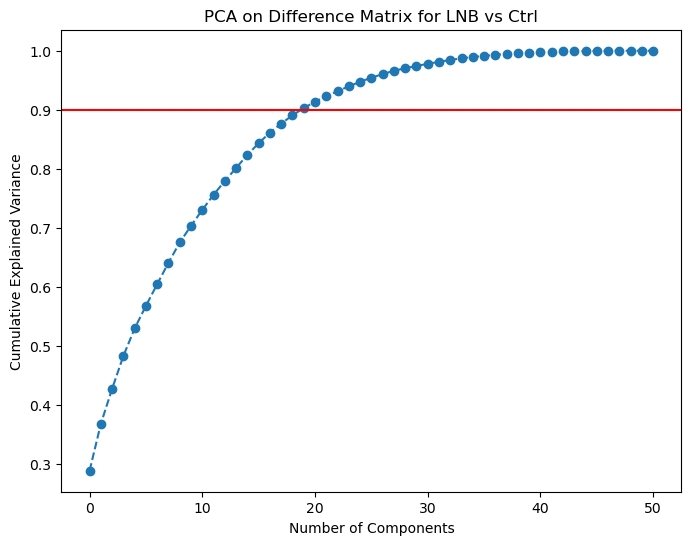


Comparison: LNB vs Ctrl

Number of Principal Components that explain 90% of the variance: 20



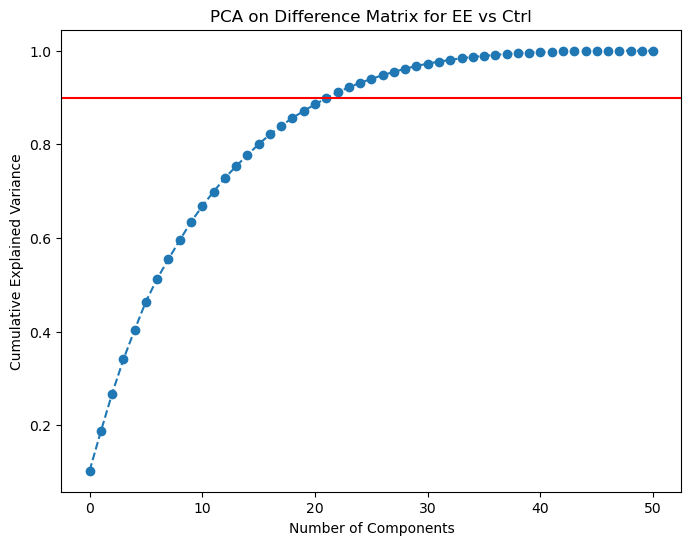


Comparison: EE vs Ctrl

Number of Principal Components that explain 90% of the variance: 23



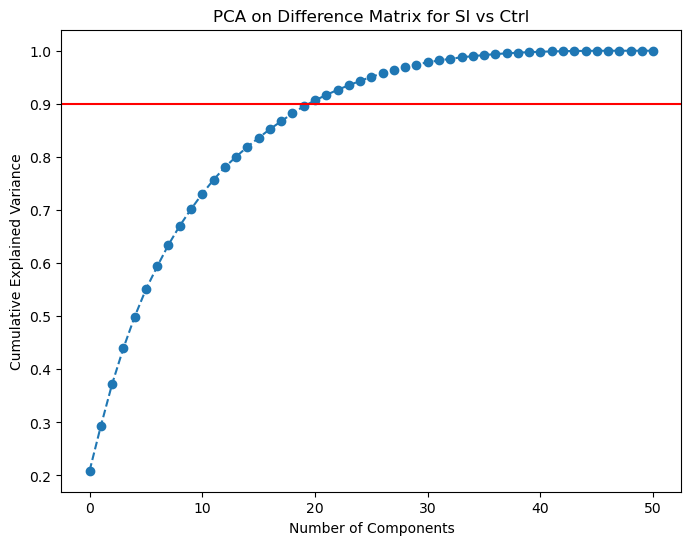


Comparison: SI vs Ctrl

Number of Principal Components that explain 90% of the variance: 21



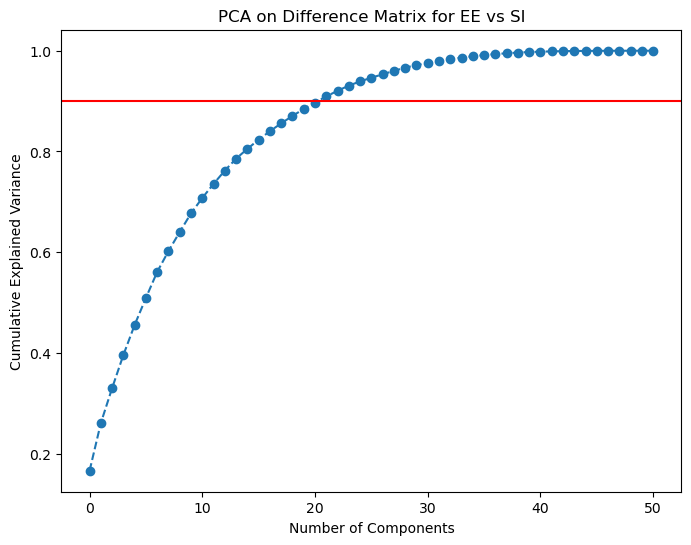


Comparison: EE vs SI

Number of Principal Components that explain 90% of the variance: 22



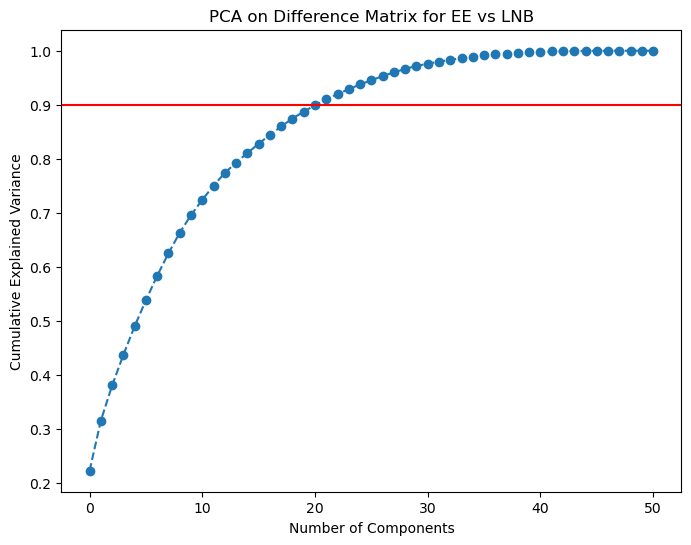


Comparison: EE vs LNB

Number of Principal Components that explain 90% of the variance: 22



In [144]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'comparisons' is a list of tuples with (mat1, mat2)
for mat1, mat2 in comparisons:

    A = females[mat1]
    B = females[mat2]

    # Step 1: Calculate the Difference Matrix
    difference_matrix = A - B
    
    # Step 2: Perform PCA on the Difference Matrix
    # Flatten the difference matrix (if needed)
    difference_matrix_flattened = difference_matrix.reshape(difference_matrix.shape[0], -1)
    
    # Initialize PCA
    pca = PCA()
    
    # Fit the PCA on the flattened difference matrix
    pca.fit(difference_matrix_flattened)
    
    # Step 3: Analyze Principal Components
    # Variance explained by each principal component
    explained_variance = pca.explained_variance_ratio_
    
    # Step 4: Calculate the number of PCs that explain 90% of the variance
    cumulative_explained_variance = np.cumsum(explained_variance)
    num_pcs_for_90_variance = np.argmax(cumulative_explained_variance >= 0.9) + 1
    
    # Plotting the explained variance
    plt.figure(figsize=(8, 6))
    plt.plot(cumulative_explained_variance, marker='o', linestyle='--')
    plt.axhline(y=0.9, color='r', linestyle='-')  # Line at 90% explained variance
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title(f'PCA on Difference Matrix for {mat1} vs {mat2}')
    plt.show()
    
    # Display the principal components and explained variance
    print(f"\nComparison: {mat1} vs {mat2}")
    
    print(f"\nNumber of Principal Components that explain 90% of the variance: {num_pcs_for_90_variance}\n")


## Stats (old)

In [2]:
EE_NormalF_Tsn = pd.read_csv('/om/scratch/Sun/mabdel03/Moseq/Redo_3/moseq_data/models/model-014-8858668/EE_Normal_Female_rows_transition_matrix.csv')

In [ ]:
EE_NormalF_Tsn

In [3]:
LNB_NormalF_Tsn = pd.read_csv('/om/scratch/Sun/mabdel03/Moseq/Redo_3/moseq_data/models/model-014-8858668/LNB_Mom_Female_rows_transition_matrix.csv')

In [ ]:
LNB_NormalF_Tsn

In [6]:
from sklearn.utils import shuffle
import numpy as np

def matrix_difference(matrix1, matrix2):
    return np.sum(np.abs(matrix1 - matrix2))

def permutation_test(matrix1, matrix2, n_permutations=10000):
    observed_diff = matrix_difference(matrix1, matrix2)
    permuted_diffs = []

    for _ in range(n_permutations):
        permuted_matrix = shuffle(matrix2, random_state=0)
        permuted_diff = matrix_difference(matrix1, permuted_matrix)
        permuted_diffs.append(permuted_diff)

    p_value = np.mean(permuted_diffs >= observed_diff)
    return observed_diff, p_value


In [7]:
observed_diff, p_value = permutation_test(EE_NormalF_Tsn.to_numpy(), LNB_NormalF_Tsn.to_numpy())
print(f"Observed Difference: {observed_diff}, p-value: {p_value}")

Observed Difference: 34.857439387769574, p-value: 1.0


In [8]:
# Assuming df1 and df2 are flattened into vectors and combined into a DataFrame
df1 = EE_NormalF_Tsn.copy()
df2 = LNB_NormalF_Tsn.copy()

from scipy.stats import ttest_rel

t_statistic, p_value = ttest_rel(df1.to_numpy().flatten(), df2.to_numpy().flatten())
print(f"Paired T-test Statistic: {t_statistic}, p-value: {p_value}")

Paired T-test Statistic: -8.835324528487136e-17, p-value: 1.0


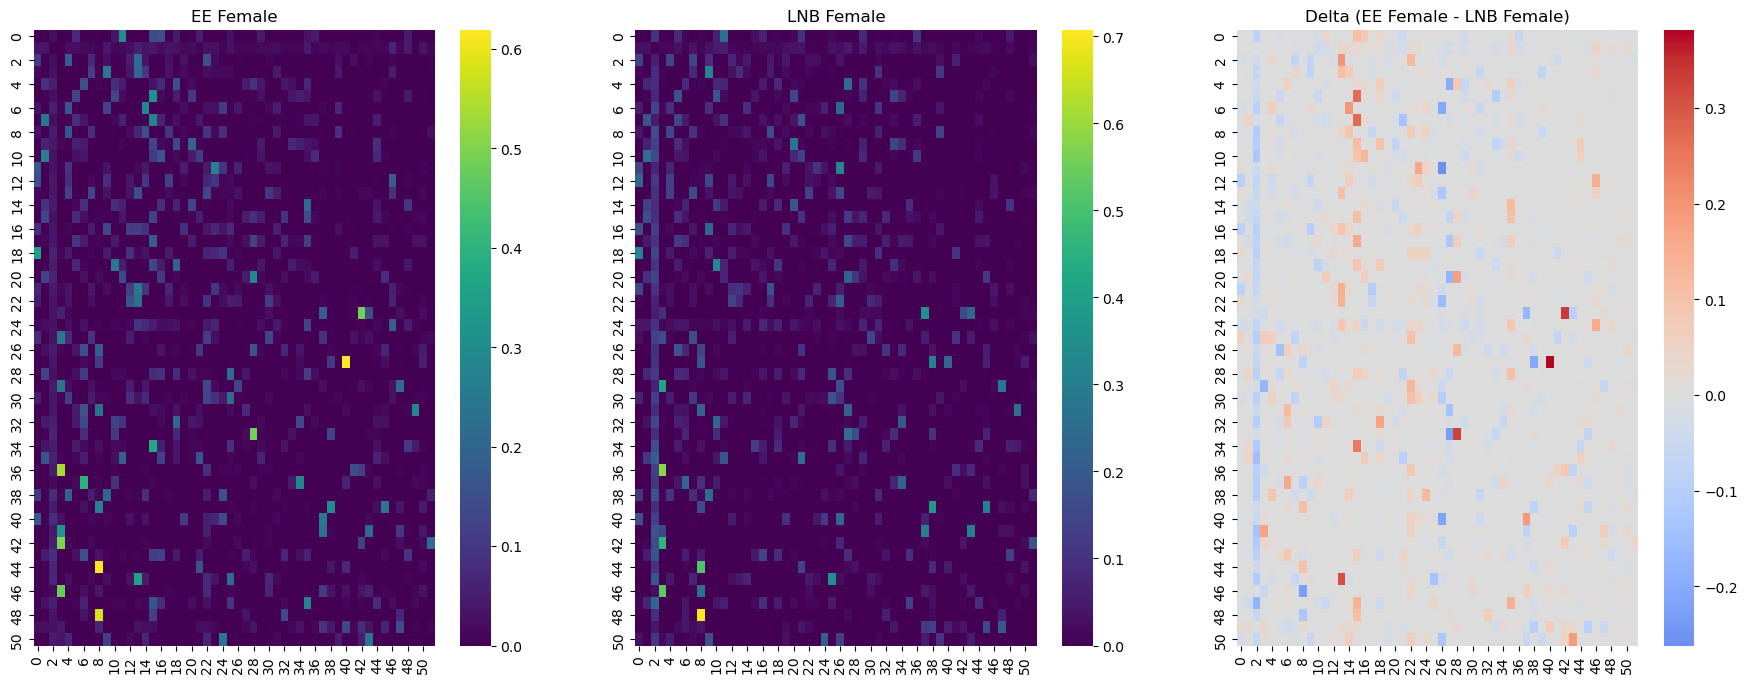

In [16]:
matrix1 = EE_NormalF_Tsn.to_numpy() 
matrix2 = LNB_NormalF_Tsn.to_numpy()

# Compute the difference (delta) matrix
delta_matrix = matrix1 - matrix2

# Plot the matrices side by side and the delta matrix
fig, axes = plt.subplots(1, 3, figsize=(22, 8))

sns.heatmap(matrix1, ax=axes[0], cmap="viridis")
axes[0].set_title('EE Female')

sns.heatmap(matrix2, ax=axes[1], cmap="viridis")
axes[1].set_title('LNB Female')

sns.heatmap(delta_matrix, ax=axes[2], cmap="coolwarm", center=0)
axes[2].set_title('Delta (EE Female - LNB Female)')

plt.show()
